# 参考: 2dCML時系列 出力関数

## 入力時系列 plot確認用

(3000, 2)


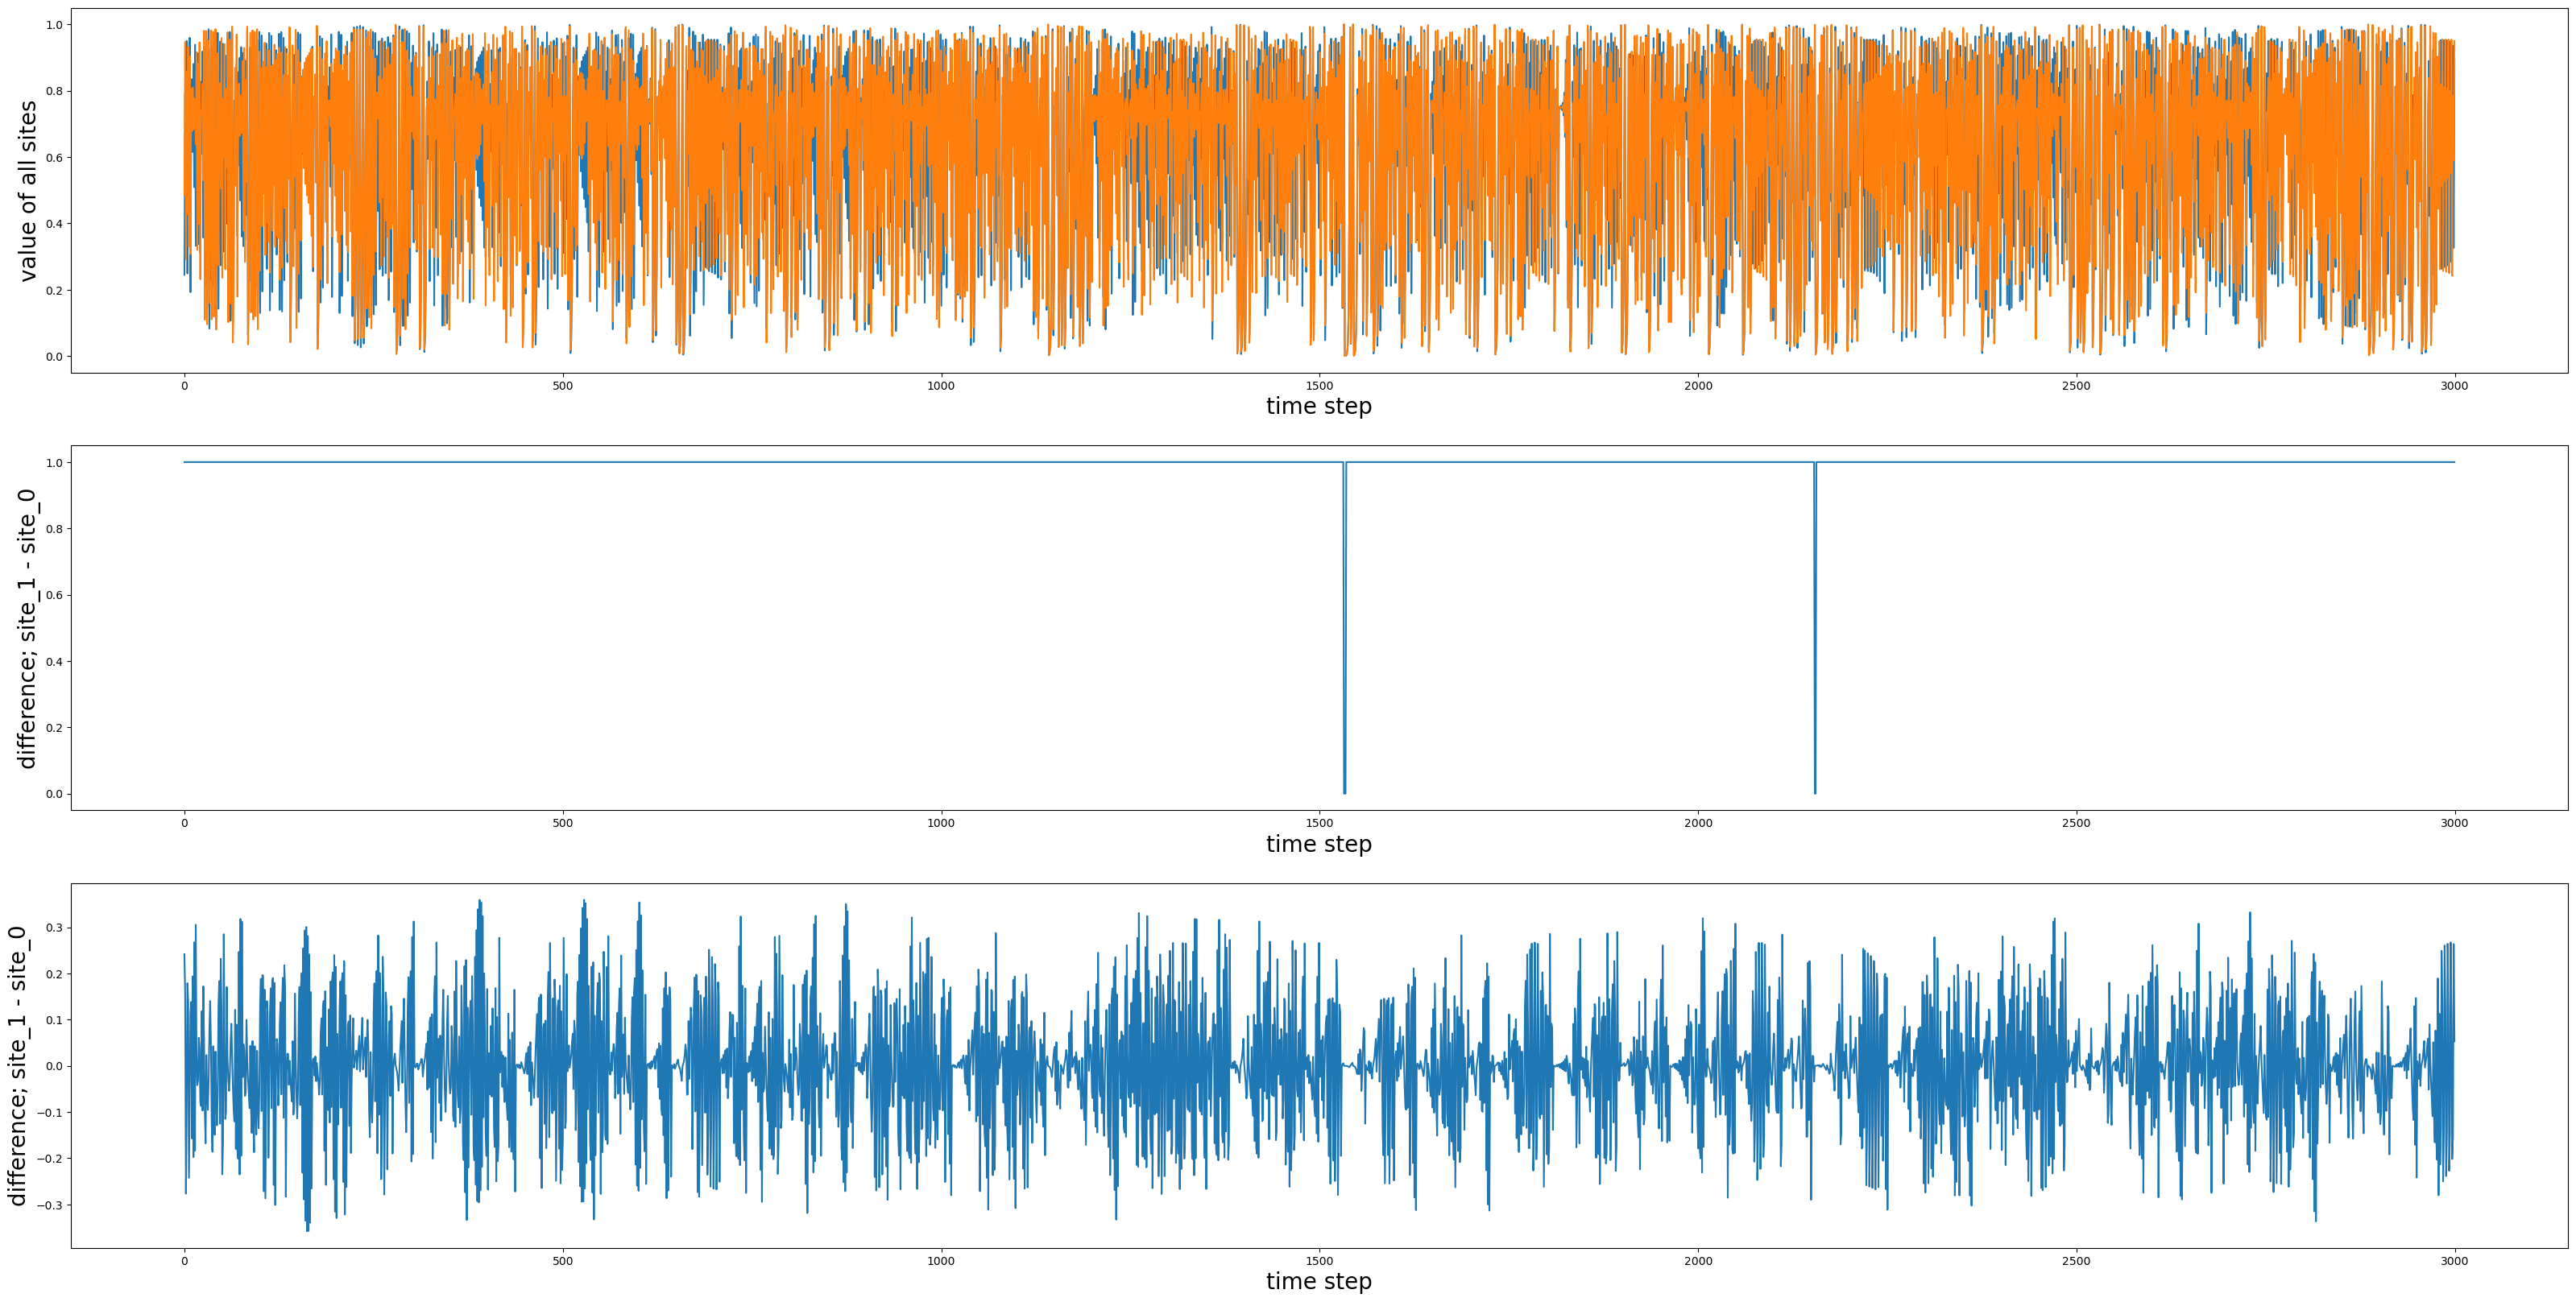

In [1]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt


L = 2      # no. of lattice sites
eps = 0.1999 # diffusive coupling strength: 
r = 4   # control parameter r:

np.random.seed(1111)
ic = np.random.uniform(0.1, 0.9, L)  # random initial condition betn. (0,1)
#print(ic)

nTransients = 200   # The iterates we'll throw away
nSteps = 3000       # The iterates we use

def logistic(r, x):
  return r*x*(1-x)

def func1(a, x):
  return 1-(a*x)*x

def next_x(f, l, x):
    x_new = np.empty(x.shape)
    for i in range(L):
        if i == 0:
            x_new[i] = (1 - eps) * f(r,x[i]) + eps * f(r,x[i+1])
        elif i == L - 1:
            x_new[i] = (1 - eps) * f(r,x[i]) + eps * f(r,x[i-1])
        elif i > 0 and i < L - 1:
            x_new[i] = (1 - eps) * f(r,x[i]) + 0.5 * eps * (f(r,x[i-1]) + f(r,x[i+1]))
    return x_new

#縦 site, 横 time(step)
states = np.empty((nSteps, L))

for i in range(nTransients):
  ic=next_x(logistic, L, ic)

states[0]=ic
for i in range(nSteps-1):
  states[i+1]=next_x(logistic, L, states[i])

print(states.shape)
plt.rcParams["figure.figsize"] = (40, 20)#(縦, 横)
fig=plt.figure()#(figsize=(100,100))
ax1=fig.subplots(3,1)
plot_length=10000
ax1[0].set_xlabel("time step",fontsize=20)
ax1[0].set_ylabel("value of all sites",fontsize=20)  

time=np.arange(nSteps)
ax1[0].plot(time[-plot_length:], states[-plot_length:])

ax1[1].set_xlabel("time step",fontsize=20)
ax1[1].set_ylabel("difference; site_1 - site_0",fontsize=20)  
ax1[1].plot(time[-plot_length:], (abs(states[-plot_length:,1]-states[-plot_length:,0])>1e-4))

ax1[2].set_xlabel("time step",fontsize=20)
ax1[2].set_ylabel("difference; site_1 - site_0",fontsize=20)  
ax1[2].plot(time[-plot_length:], (states[-plot_length:,1]-states[-plot_length:,0]))
plt.show()

# 参考 color map

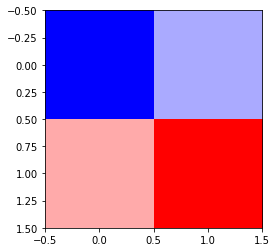

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
im_array = np.array([
    [0, 85],
    [170, 255]
])
 
plt.imshow(im_array, cmap='bwr')
 
plt.show()

# やること:
1. 2種類の入力: 自発活動, 観測用入力(random) をふたつ生成する関数を"Input class"内に作成.
2. update 関数に2入力を加えるよう, 変更を加える
3. output関数をtrain関数の代わりに作成, predict関数は無視. 出力も無視
4. 何をプロットして図示するか? 状態値?自発活動?
5. ESNでintermittencyを示す論文の再現
6. IPC計算, input:u_ex, output:??後で相談

memo: 
1. DESN内predict関数, Readout class, ここでは不使用

参考:

1. 元のESNを参考に作ろう. コードの綺麗さも真似する.
2. 自class内で自メンバ関数を呼ぶ時, -> self.func(引数)
引数にselfの代入不要.

## 参考: コードを書く時:
1. フローチャートやるべきこと(修正点など)を列挙, 一つずつ対処する.
目次に書くといいかも. (目次は必ず作成しろ.)

2. 余計に考えるより, 思いついた言葉を活字にして記録. その後, 整理.

# ESN, output, input class
input, output, middle layer

In [ ]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import networkx as nx
from numpy.random import RandomState
import matplotlib.pyplot as plt

class Input_external:
    def __init__(self, dim_u, dim_x, input_scale, dtype=np.float32, rseed=0):
        '''
        dim_u: Dimension of the input
        dim_x: Dimension of the reservoir states = Number of nodes in the Reservoir Network
        input_scale: Scaling coefficient for the input
        '''
        np.random.seed(seed=rseed)
        self.dtype = dtype
        self.w_in = np.random.uniform(-input_scale, input_scale, (dim_x, dim_u))
        self.w_in = self.w_in.astype(self.dtype)
    
    def __call__(self, u):
        u = u.astype(self.dtype)
        return np.dot(self.w_in, u)

class Input_spon:
    def __init__(self, dim_u_spon, dim_x, dtype=np.float32, rseed=0):
        '''
        dim_u_spon: Dimension of the input from sponttaneous activities
        dim_x: Dimension of the reservoir states = Number of nodes in the Reservoir Network
        input_scale: Scaling coefficient for the input
        '''
        np.random.seed(seed=rseed)
        input_scale=1.0 # variant for buf
        self.dtype = dtype
        self.w_in = np.random.uniform(-input_scale, input_scale, (dim_x, dim_u_spon))
        self.w_in = self.w_in.astype(self.dtype)

        self.eps=0.20 # diffusive coupling strength
        self.r=4.0 # control parameter r
        L = 2      # no. of lattice sites
        ic = np.random.uniform(0.1, 0.9, (L, dim_u_spon))  # random initial condition betn. (0,1)
        print("spon_act_CML2d_ic = ", ic)
        self.CML2d=ic
        self.x_in_series=[] #1st_dim: time, 2nd_dim: input_dim(dim_u_spon)
    
    def logistic(self, r, xforlog):
        return r*xforlog*(1-xforlog)
    
    def func1(self, a, x):
        return 1-(a*x)*x
    
    def next_x(self, f, x_2d):
        x_new = np.empty(x_2d.shape)
        x_new[0] = (1 - self.eps) * f(self.r,x_2d[0]) + self.eps * f(self.r,x_2d[1])
        x_new[1] = (1 - self.eps) * f(self.r,x_2d[1]) + self.eps * f(self.r,x_2d[0])
        return x_new

    def get_x_in(self):
        return np.array(self.x_in_series)

    def __call__(self):
        self.CML2d = self.next_x(self.logistic, self.CML2d).astype(self.dtype)# intermittent activities 2dCML or ESNnetwork
        self.x_in_spon=self.CML2d[0]-self.CML2d[1]
        #print(self.CML2d)
        self.x_in_series.append(self.x_in_spon)
        return np.dot(self.w_in, self.x_in_spon)# x_in is row or clumn??????

class ESN:
    def __init__(self, dim_x, activation_func=np.tanh, dtype=np.float32, rho=0.9,
        x_init=None, rseed=None, density=None):
        '''
        dim_x:           Dimension of the reservori states = Number of nodes in the Reservoir Network
        activation_func: Activation function to evolve the previous internal states
        rho:             Specified spectral radius for the internal weights matrix
        density:         Density of connection in the Reservoir layer
        '''
        self.dim_x = dim_x
        self.f = activation_func
        self.dtype = dtype
        self.rho = rho # speficy the spectral radius
        
        if x_init is None:
            self.x_init = np.zeros(dim_x, dtype=self.dtype)
        else:
            self.x_init = np.array(x_init, dtype=self.dtype)
        self.x = np.array(self.x_init)
        self.rseed = rseed
        self.rnd = RandomState(rseed)
        
        # initializing internal connections
        self.reset_weight(density)
    
    def reset_weight(self, density=None):
        self.density = 1.0 if density is None else density
        num_edges = int(self.dim_x * (self.dim_x - 1) * self.density / 2)
        
        G = nx.gnm_random_graph(self.dim_x, num_edges, self.rseed)
        self.w_net = np.array(nx.to_numpy_matrix(G))
        self.w_net = self.w_net.astype(self.dtype)
        self.w_net *= self.rnd.uniform(-1.0, 1.0, (self.dim_x, self.dim_x))
        
        # Compute spectral radius
        eigv_list = np.linalg.eig(self.w_net)[0]
        spectral_radius = np.max(np.abs(eigv_list))

        # Normalize the spectral radius
        self.w_net  *= self.rho / spectral_radius
    
    def f_act(self, x=None):
        if x is None:
            x = self.x
        return self.f(x)
    
    def update(self, x_in):
        x_in = x_in.astype(self.dtype)
        self.x = self.f_act(np.dot(self.w_net, self.x) + x_in)
    
    def reset_states(self, x_init=None):
        if x_init is None:
            x_init = self.x_init
        self.x = np.array(x_init)

    def get_states(self):
        return self.x

class Readout:
    def __init__(self, dim_x, dim_out, rseed=0):
        np.random.seed(seed=rseed)
        self.w_out = np.random.normal(size=(dim_out, dim_x))
    
    def __call__(self, x):
        return np.dot(self.w_out, x)
    
    def set_weight(self, w_out_opt):
        self.w_out = w_out_opt


## 参考: Reservoir学習時の誤差逆伝播 class

In [ ]:
class Pinv_opt:
    def __init__(self):
        self.X = [] # Store the reservoir states
        self.Y = [] # Store the output
    
    def add_data(self, vec_x, vec_y):
        vec_x = np.reshape(vec_x, (-1, 1))
        vec_y = np.reshape(vec_y, (-1, 1))
        self.X.append(vec_x)
        self.Y.append(vec_y)
    
    def solve(self):
        # Training data   X: Dim = (dim_x + 1, num_steps) with bias
        # Training target Y: Dim = (dim_out, num_steps)
        self.X = np.concatenate(self.X, axis=1)
        self.X = np.concatenate([np.ones((1, self.X.shape[1])), self.X], axis=0) 
        self.Y = np.concatenate(self.Y, axis=1) 
        # print('Data Shape', self.X.shape, self.Y.shape)
        # Solve WX = Y by Moorse-Penrose pseudo-inverse matrix
        # W_out has Dim = (dim_out, dim_x + 1)
        w_out_opt = np.dot(self.Y, np.linalg.pinv(self.X)) 
        return w_out_opt


# Discrete ESN for checking state values

In [ ]:
class DESN_2kindsInput(ESN):
    '''
    Discrete-time echo state network
    Inherit from ESN abstract class
    Add the Input and Readout layers
    
    #Variables including default params have order to define in any function 
    '''
    def __init__(self, dim_u_ex, dim_u_spon, dim_rv, input_scale, dim_out=0,**kwargs):
        #dim_rv: Dimension of the reservoir states
        super(DESN_2kindsInput, self).__init__(dim_rv, **kwargs)#assign dim_rv to dim_x
        #create instance
        self.Input_external = Input_external(dim_u_ex, dim_rv, input_scale)
        self.Input_spon = Input_spon(dim_u_spon, dim_rv)
        self.Readout = Readout(dim_rv, dim_out)
        self.states_series=[]

    def one_step(self, u_in):
        '''
        One-step evolution
        '''
        # Contribution from input
        x_in_external = self.Input_external(u_in)
        # Contribution from spontaneous activities
        x_in_spon = self.Input_spon()
        # Update with previous states and activation function
        self.update(x_in_external+x_in_spon)

    def time_elapse(self, u_seq, washout_len = 200):
        '''
        Do not use the data in the washout phase for training
        '''
        for i in range(len(u_seq)):
            # Update the reservoir states
            self.one_step(u_seq[i])
            if i >= washout_len: 
              # True: use data
              self.states_series.append(self.get_states())
        return np.array(self.states_series)
    
    def predict(self, u_seq):
        '''
        Given the input sequence u_seq, predict the unknown output sequence
        Using the trained readout weights
        '''
        Y_pred_seq = []
        for i in range(len(u_seq)):
            self.one_step(u_seq[i])
            x_bias = np.concatenate([np.ones(1), self.x])
            y_pred = self.Readout(x_bias)
            Y_pred_seq.append(y_pred)
        return np.array(Y_pred_seq)

# Observation of DiscreteESN with spontaneous acts

verbose: くどい, 冗長だ n. 詳細
np.diff(): 渡した配列の階差数列を配列で返す関数

In [ ]:
def DESN_observer(u_ex, dim_rv, density, input_scale, rho, rseed, plot=True, verbose=False):
    # Obtain the dimension of input and output
    dim_u_ex = u_ex.shape[1]
    Time_leng=u_ex.shape[0]
    dim_u_spon=1
    #dim_out = train_y.shape[1]
    #print("dim_out = ",dim_out)
    
    # Define the model
    model = DESN_2kindsInput(dim_u_ex=dim_u_ex, dim_u_spon=dim_u_spon, dim_rv=dim_rv, 
                             density=density, input_scale=input_scale, rho=rho, rseed=rseed)
    
    # Time elapsed (時間が経過した-> 時間経過)
    states_series = model.time_elapse(u_ex) # 1st_dim: time, 2nd: nodes.
    x_in_spon=model.Input_spon.get_x_in()
    # Predict
    """
    test_pred = model.predict(test_u)
    print("test_pred.shape", test_pred.shape)
    """
    # Evaluate
    
    # For Debug
    if verbose == True:
        print("Debug")
        print("dim_u = ",dim_u)
        print("x_in_spon.shape = ", x_in_spon.shape)
        print("states_series.shape = ", states_series.shape)
    
    # Plot the target and predict
    if plot == True:
        plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
        plt.rcParams['font.size'] = 20
        fig=plt.figure()
        ax1=fig.subplots(3,1)

        time=np.arange(Time_leng)
        ax1[0].plot(time, x_in_spon)

        bar1=ax1[1].imshow(states_series.T, cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[1].set_xlabel('time')
        ax1[1].set_ylabel('nodes')
        fig.colorbar(bar1, ax=ax1[1])

        bar2=ax1[2].imshow(states_series.T[:, -300:], cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[2].set_xlabel('time')
        ax1[2].set_ylabel('nodes')
        fig.colorbar(bar2, ax=ax1[2])

        plt.show()
    return 


spon_act_CML2d_ic =  [[0.64225323]
 [0.31600638]]
Debug
dim_u =  1
x_in_spon.shape =  (5000, 1)
states_series.shape =  (4800, 100)


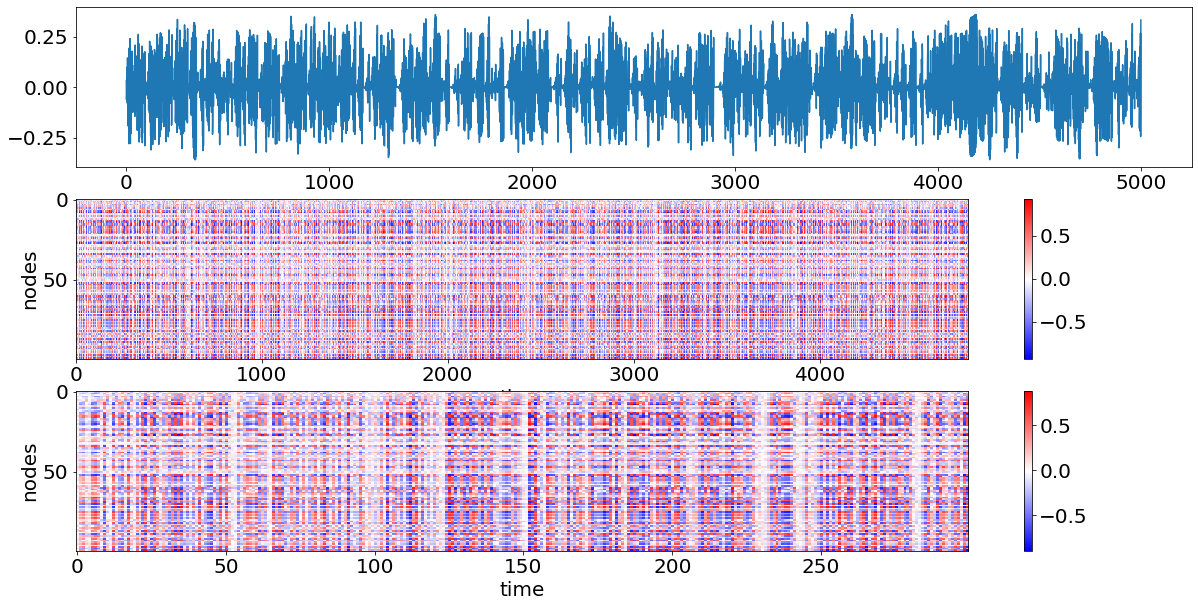

In [ ]:
np.random.seed(1010)
dim_rv=100
dim_u=1
Time_leng=5000

input_scale=1.0
rho=0.5
density=1.0

u_ex=np.random.uniform(-input_scale, input_scale, (Time_leng, dim_u))
rseed=1111
DESN_observer(u_ex, dim_rv, density, input_scale, rho, rseed, plot=True, verbose=True)

# 完成版11/15

## ESN, output, input class
input, output, middle layer

In [ ]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import networkx as nx
from numpy.random import RandomState
import matplotlib.pyplot as plt
import copy

class Input_external:
    def __init__(self, dim_u, dim_x, input_scale, dtype=np.float32, rseed=0):
        '''
        dim_u: Dimension of the input
        dim_x: Dimension of the reservoir states = Number of nodes in the Reservoir Network
        input_scale: Scaling coefficient for the input
        '''
        np.random.seed(seed=rseed)
        self.dtype = dtype
        #only first neuron receives noise
        #self.w_in = np.zeros((dim_x, dim_u))
        #self.w_in[:, 0]=np.random.uniform(-input_scale, input_scale, dim_u).T
        self.w_in = np.random.uniform(-input_scale, input_scale, (dim_x, dim_u))
        self.w_in = self.w_in.astype(self.dtype)

    
    def __call__(self, u):
        u = u.astype(self.dtype)
        return np.dot(self.w_in, u)

class Input_spon:
    def __init__(self, dim_u_spon, dim_x, input_scale=1.0, eps=0.20, r=4.0, dtype=np.float32, rseed=0):
        '''
        dim_u_spon: Dimension of the input from sponttaneous activities
        dim_x: Dimension of the reservoir states = Number of nodes in the Reservoir Network
        input_scale: Scaling coefficient for the input
        '''
        np.random.seed(seed=rseed)
        self.input_scale=input_scale # variant for buf
        self.dtype = dtype
        self.w_in = np.random.uniform(-self.input_scale, self.input_scale, (dim_x, dim_u_spon))
        self.w_in = self.w_in.astype(self.dtype)

        self.eps=eps # diffusive coupling strength
        self.r=r # control parameter r
        L = 2      # no. of lattice sites
        ic = np.random.uniform(0.1, 0.9, (L, dim_u_spon))  # random initial condition betn. (0,1)
        #print("spon_act_CML2d_ic = ", ic)
        self.CML2d=ic
        self.x_in_series=[] #1st_dim: time, 2nd_dim: input_dim(dim_u_spon)
    
    def logistic(self, r, xforlog):
        return r*xforlog*(1-xforlog)
    
    def func1(self, a, x):
        return 1-(a*x)*x
    
    def next_x(self, f, x_2d):
        x_new = np.empty(x_2d.shape)
        x_new[0] = (1 - self.eps) * f(self.r,x_2d[0]) + self.eps * f(self.r,x_2d[1])
        x_new[1] = (1 - self.eps) * f(self.r,x_2d[1]) + self.eps * f(self.r,x_2d[0])
        return x_new

    def get_x_in(self):
        return np.array(self.x_in_series)

    def __call__(self):
        self.CML2d = self.next_x(self.logistic, self.CML2d).astype(self.dtype)# intermittent activities 2dCML or ESNnetwork
        self.x_in_spon=self.CML2d[0]-self.CML2d[1]
        #print(self.CML2d)
        self.x_in_series.append(self.x_in_spon)
        return np.dot(self.w_in, self.x_in_spon)# x_in is row or clumn??????

class ESN1:
    def __init__(self, dim_x, activation_func=np.tanh, dtype=np.float32, rho=0.9,
        x_init=None, rseed=None, density=None):
        '''
        dim_x:           Dimension of the reservori states = Number of nodes in the Reservoir Network
        activation_func: Activation function to evolve the previous internal states
        rho:             Specified spectral radius for the internal weights matrix
        density:         Density of connection in the Reservoir layer
        '''
        self.dim_x = dim_x
        self.f = activation_func
        self.dtype = dtype
        self.rho = rho # speficy the spectral radius
        
        if x_init is None:
            self.x_init = np.zeros(dim_x, dtype=self.dtype)
        else:
            self.x_init = np.array(x_init, dtype=self.dtype)
        self.x = np.array(self.x_init)
        self.rseed = rseed
        self.rnd = RandomState(rseed)
        
        # initializing internal connections
        self.reset_weight(density)
    
    def reset_weight(self, density=None):
        
        self.density = 1.0 if density is None else density
        num_edges = int(self.dim_x * (self.dim_x - 1) * self.density / 2)
        
        G = nx.gnm_random_graph(self.dim_x, num_edges, self.rseed)
        self.w_net = np.array(nx.to_numpy_matrix(G))
        self.w_net = self.w_net.astype(self.dtype)
        self.w_net *= self.rnd.uniform(-1.0, 1.0, (self.dim_x, self.dim_x))
        
        # Compute spectral radius
        eigv_list = np.linalg.eig(self.w_net)[0]
        spectral_radius = np.max(np.abs(eigv_list))

        # Normalize the spectral radius
        self.w_net  *= self.rho / spectral_radius
        """
        self.w_net  =[[1.0, 0.1, -0.9, -0.3],
                      [0.5, 0.9, 0.2, 0.0],
                      [-0.7, 0.4, -0.3, 0.1],
                      [0.5, 0.1, 0.2, 1.0]]
        """

    def f_act(self, x=None):
        if x is None:
            x = self.x
            print("error")
        return self.f(x)
    
    def update(self, x_in):
        x_in = x_in.astype(self.dtype)
        
        self.x = self.f_act(np.dot(self.w_net, self.x) + x_in)
        #print("self.x[0] = ", buf_x[0], "  (np.dot(self.w_net, self.x) + x_in)[0] = ", (np.dot(self.w_net, self.x) + x_in)[0])
        #print("np.tanh( (np.dot(self.w_net, self.x) + x_in)[0]) =", np.tanh((np.dot(self.w_net, self.x) + x_in)[0]) )
        """
        #print(x_in[0])
        x_for_actfunc=np.dot(self.w_net, self.x) + x_in 
        #x_for_actfunc=copy.copy(x_for_actfunc)
        # self.x_init = np.zeros(dim_x, dtype=self.dtype)
        print("self.x.shape = ", self.x.shape)
        print("x_for_actfunc.shape = ", x_for_actfunc.shape )
        for i in range(self.dim_x):
            self.x[i] = np.tanh(x_for_actfunc[i])
            #print("i =", i, "  self.x[i] = ", self.x[i], "  x_for_actfunc[i] = ", x_for_actfunc[i])
        #print("i =", 1, "  self.x[1] = ", self.x[1], "  x_for_actfunc[1] = ", x_for_actfunc[1])
        #"""
        
    def reset_states(self, x_init=None):# not used 
        if x_init is None:
            x_init = self.x_init
        self.x = np.array(x_init)

    def get_states(self):
        return self.x

class Readout:
    def __init__(self, dim_x, dim_out, rseed=0):
        np.random.seed(seed=rseed)
        self.w_out = np.random.normal(size=(dim_out, dim_x))
    
    def __call__(self, x):
        return np.dot(self.w_out, x)
    
    def set_weight(self, w_out_opt):
        self.w_out = w_out_opt


## Discrete ESN for checking state values

In [ ]:
class DESN_2kindsInput_1(ESN1):
    '''
    Discrete-time echo state network
    Inherit from ESN abstract class
    Add the Input and Readout layers
    
    #Variables including default params have order to define in any function 
    '''
    def __init__(self, dim_u_ex, dim_u_spon, dim_rv, input_scale, activation_func, spon_eps=0.20, spon_r=4.0, dim_out=0,**kwargs):
        #dim_rv: Dimension of the reservoir states
        super(DESN_2kindsInput_1, self).__init__(dim_rv, activation_func=activation_func, **kwargs)#assign dim_rv to dim_x
        #create instance
        self.Input_external = Input_external(dim_u_ex, dim_rv, input_scale)
        self.Input_spon = Input_spon(dim_u_spon, dim_rv, input_scale=input_scale, eps=spon_eps, r=spon_r)
        
        self.Readout = Readout(dim_rv, dim_out)
        self.states_series=[]
        self.dim_u_spon=dim_u_spon
        self.dim_u_ex=dim_u_ex

    def one_step(self, u_in):
        '''
        One-step evolution
        '''
        # Contribution from input
        x_in_external = self.Input_external(u_in)
        # Contribution from spontaneous activities
        x_in_spon = self.Input_spon()
        # Update with previous states and activation function
        self.update( (x_in_external + x_in_spon)/(self.dim_u_spon + self.dim_u_ex) )

    def time_elapse(self, u_seq, washout_len = 200):
        '''
        Do not use the data in the washout phase for training
        '''
        for i in range(len(u_seq)):
            # Update the reservoir states
            self.one_step(u_seq[i])
            if i >= washout_len: 
              # True: use data
              self.states_series.append(self.get_states())
        return np.array(self.states_series)
    
    def predict(self, u_seq):
        '''
        Given the input sequence u_seq, predict the unknown output sequence
        Using the trained readout weights
        '''
        Y_pred_seq = []
        for i in range(len(u_seq)):
            self.one_step(u_seq[i])
            x_bias = np.concatenate([np.ones(1), self.x])
            y_pred = self.Readout(x_bias)
            Y_pred_seq.append(y_pred)
        return np.array(Y_pred_seq)

## Observation of DESN with spontaneous acts

np.diff(): 渡した配列の階差数列を配列で返す関数

In [ ]:
def DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, input_scale, rho, rseed, activation_func=np.tanh, 
                    spon_eps=0.20, spon_r=4.0, plot=True, verbose=False):
    # Obtain the dimension of input and output
    dim_u_ex = u_ex.shape[1]
    Time_leng=u_ex.shape[0]
    dim_u_spon=dim_u_spon
    #dim_out = train_y.shape[1]
    #print("dim_out = ",dim_out)
    
    # Define the model
    model = DESN_2kindsInput_1(dim_u_ex=dim_u_ex, dim_u_spon=dim_u_spon, dim_rv=dim_rv, 
                             density=density, input_scale=input_scale, activation_func=activation_func, 
                             spon_eps=spon_eps, spon_r=spon_r, rho=rho, rseed=rseed)
    
    washout_len=1000
    # Time elapsed (時間が経過した-> 時間経過)
    states_series = model.time_elapse(u_ex, washout_len=washout_len) # 1st_dim: time, 2nd: nodes.
    x_in_spon=model.Input_spon.get_x_in()
    # Predict
    """
    test_pred = model.predict(test_u)
    print("test_pred.shape", test_pred.shape)
    """
    # Evaluate
    
    # For Debug
    if verbose == True:
        print("Debug")
        print("dim_u = ",dim_u)
        print("x_in_spon.shape = ", x_in_spon.shape)
        print("states_series.shape = ", states_series.shape)
        #print(states_series[0])

     # Plot the target
    if (plot == True and dim_u_spon == 0):
        plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
        plt.rcParams['font.size'] = 20
        fig=plt.figure()
        ax1=fig.subplots(2,1)

        time=np.arange(Time_leng)

        bar1=ax1[0].imshow(states_series.T, cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[0].set_xlabel('time')
        ax1[0].set_ylabel('nodes')
        fig.colorbar(bar1, ax=ax1[1])

        bar2=ax1[1].imshow(states_series.T[:, -300:], cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[1].set_xlabel('time')
        ax1[1].set_ylabel('nodes')
        fig.colorbar(bar2, ax=ax1[1])
    
    # Plot the targett with spon_act
    if (plot == True and dim_u_spon>0):
        plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
        plt.rcParams['font.size'] = 20
        fig=plt.figure()
        ax1=fig.subplots(3,1)

        time=np.arange(Time_leng)
        ax1[0].plot(time, x_in_spon)

        bar1=ax1[1].imshow(states_series.T, cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[1].set_xlabel('time')
        ax1[1].set_ylabel('nodes')
        fig.colorbar(bar1, ax=ax1[1])

        bar2=ax1[2].imshow(states_series.T[:, -300:], cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[2].set_xlabel('time')
        ax1[2].set_ylabel('nodes')
        fig.colorbar(bar2, ax=ax1[2])

        plt.show()
    return washout_len, states_series


Debug
dim_u =  1
x_in_spon.shape =  (5000, 1)
states_series.shape =  (4000, 100)


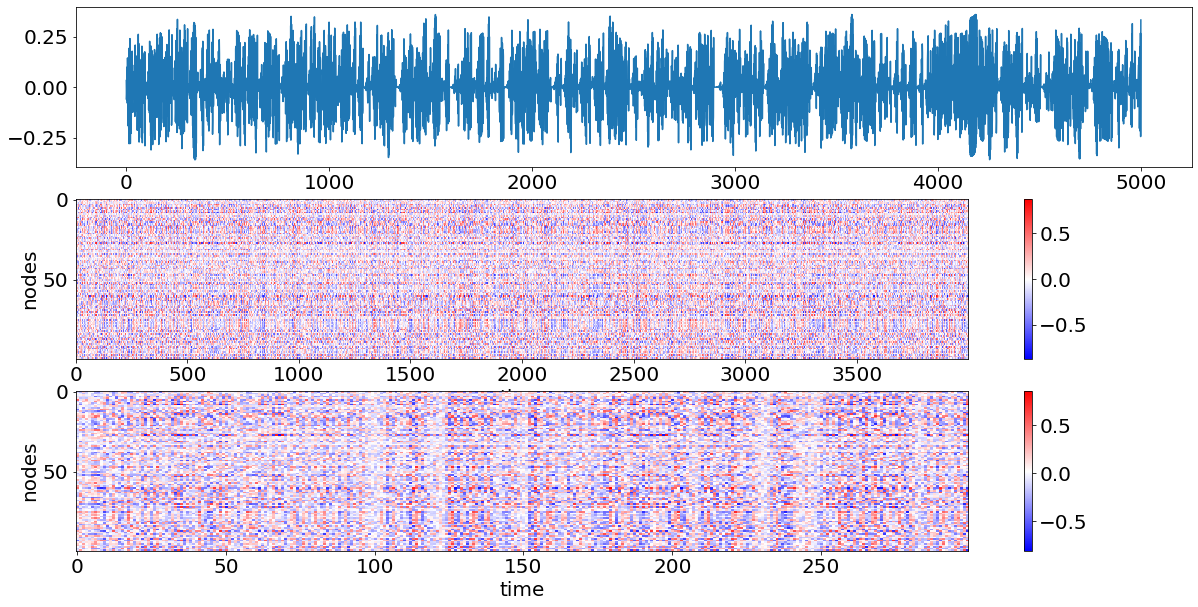

In [ ]:
np.random.seed(1010)
dim_u_spon=1
dim_rv=100
dim_u=1
Time_leng=5000

input_scale=1.0
rho=0.9
density=1.0

u_ex=np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))
#print(u_ex)
rseed=1111
washout_len, states_series1=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, input_scale, rho, rseed, spon_eps=0.20, spon_r=4.0, plot=True, verbose=True)

# Change spectral radius

## 1spon, 1external

<function matplotlib.pyplot.show(*args, **kw)>

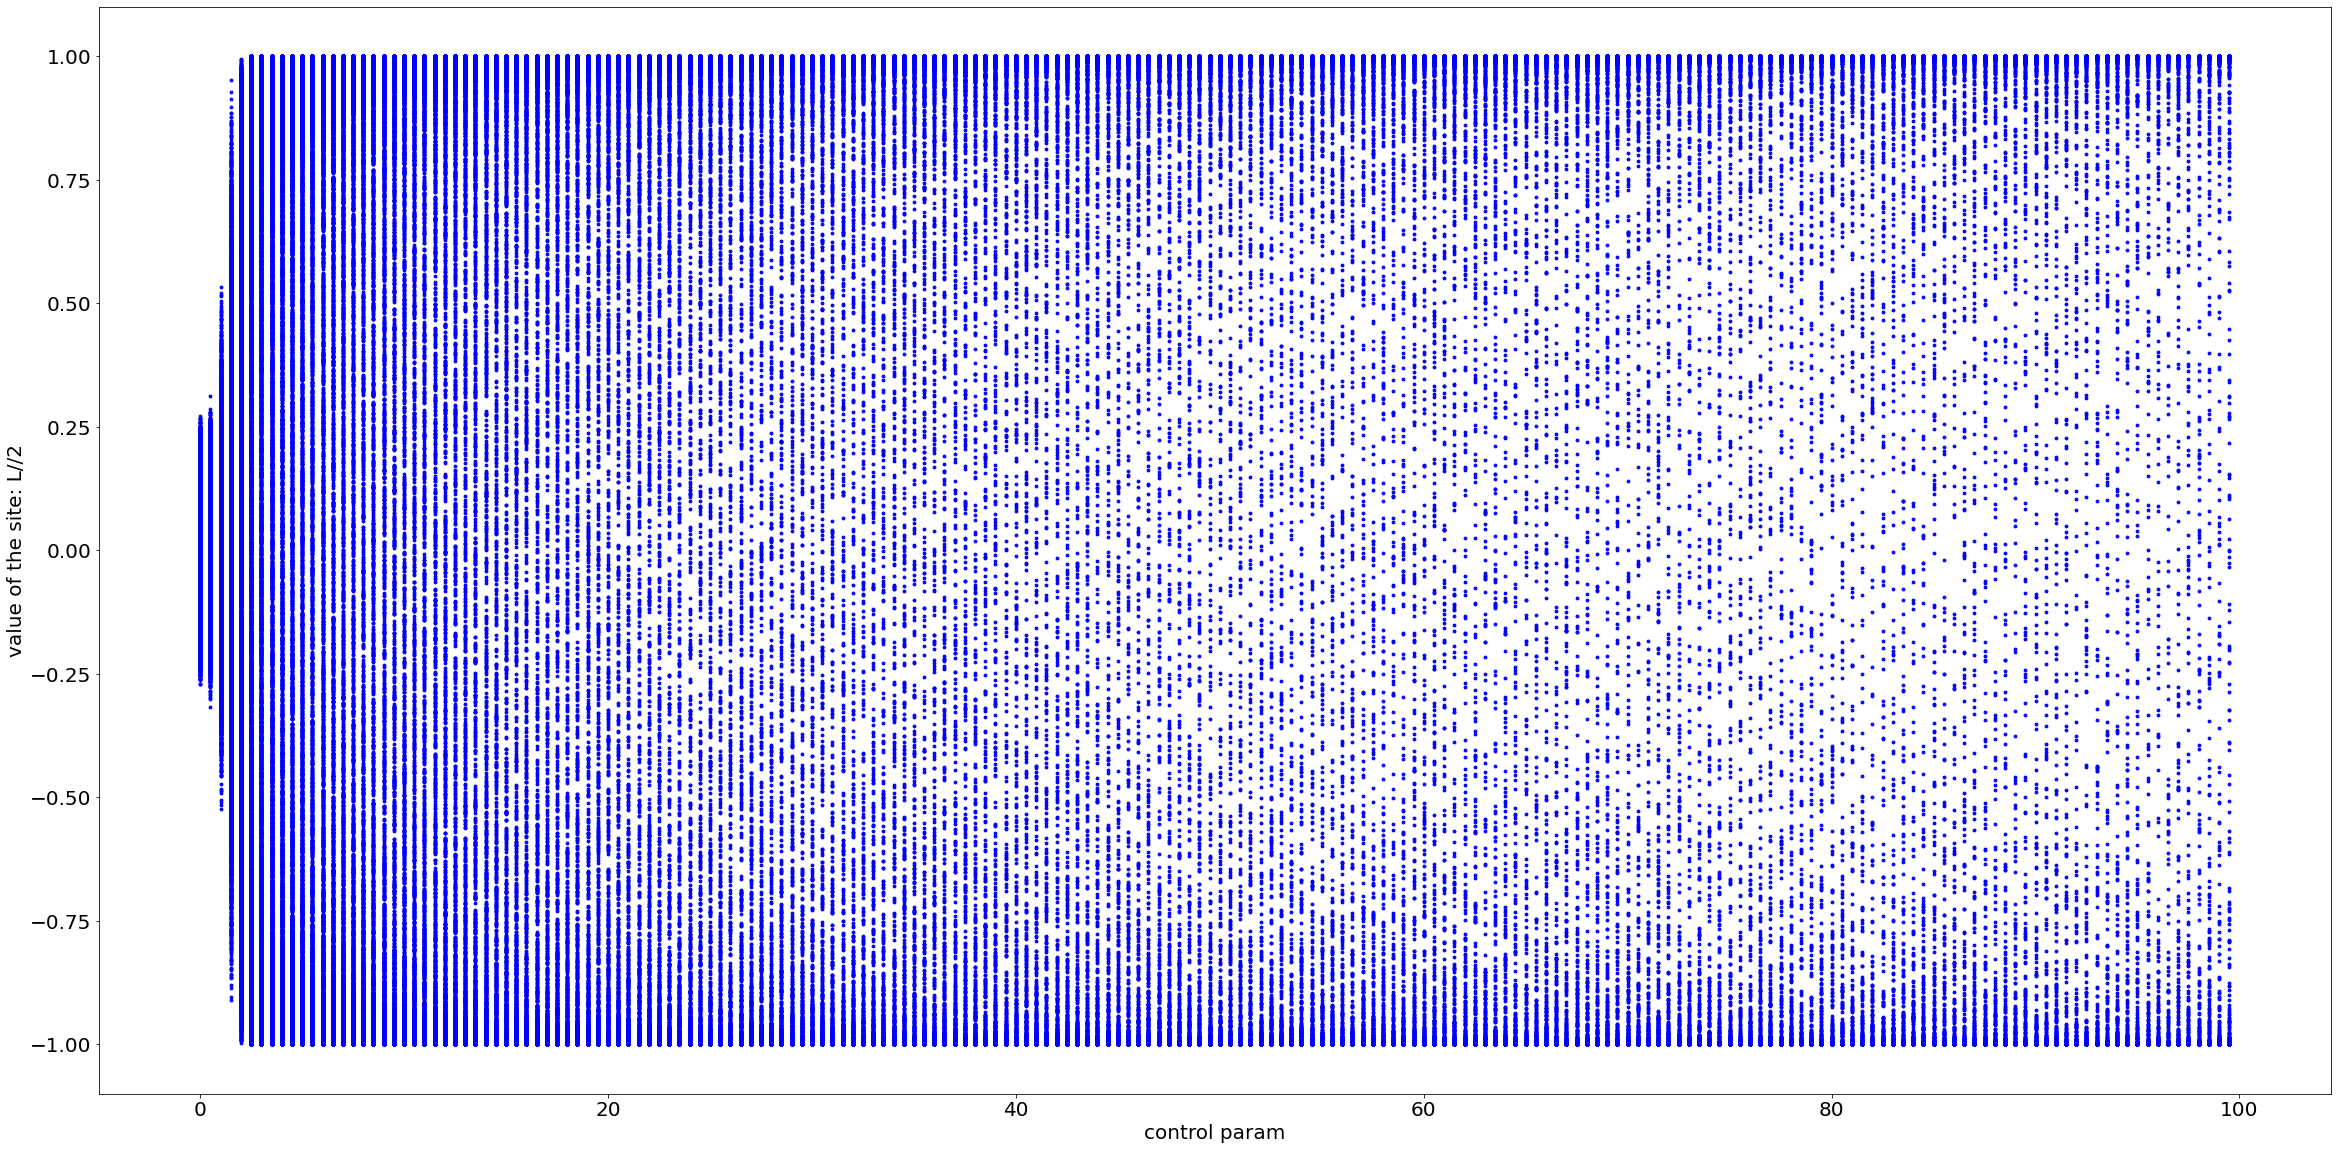

In [ ]:
np.random.seed(1010)
dim_u_spon=1
dim_rv=100
dim_u=1
Time_leng=8000

input_scale=1.0
density=1.0

u_ex=np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))
#print(u_ex)
rseed=1111

pLow = 0.01
pHigh = 100.00
nSteps = 200       # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

rhos = np.arange(pLow, pHigh, pInc)

plt.rcParams["figure.figsize"] = (40, 20)#(縦, 横)
fig=plt.figure()#(figsize=(100,100))
ax1=fig.subplots(1,1)
ax1.set_xlabel("control param",fontsize=20)
ax1.set_ylabel("value of the site: L//2",fontsize=20) 
j_ofx=1
for rho in rhos:
    washout_len, states_series=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, input_scale, rho, 
                                                rseed, spon_eps=0.20, spon_r=4.0, plot=False, verbose=False)
    ax1.scatter(rho*np.ones(Time_leng-washout_len), states_series[:,j_ofx], s=8, c='b')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

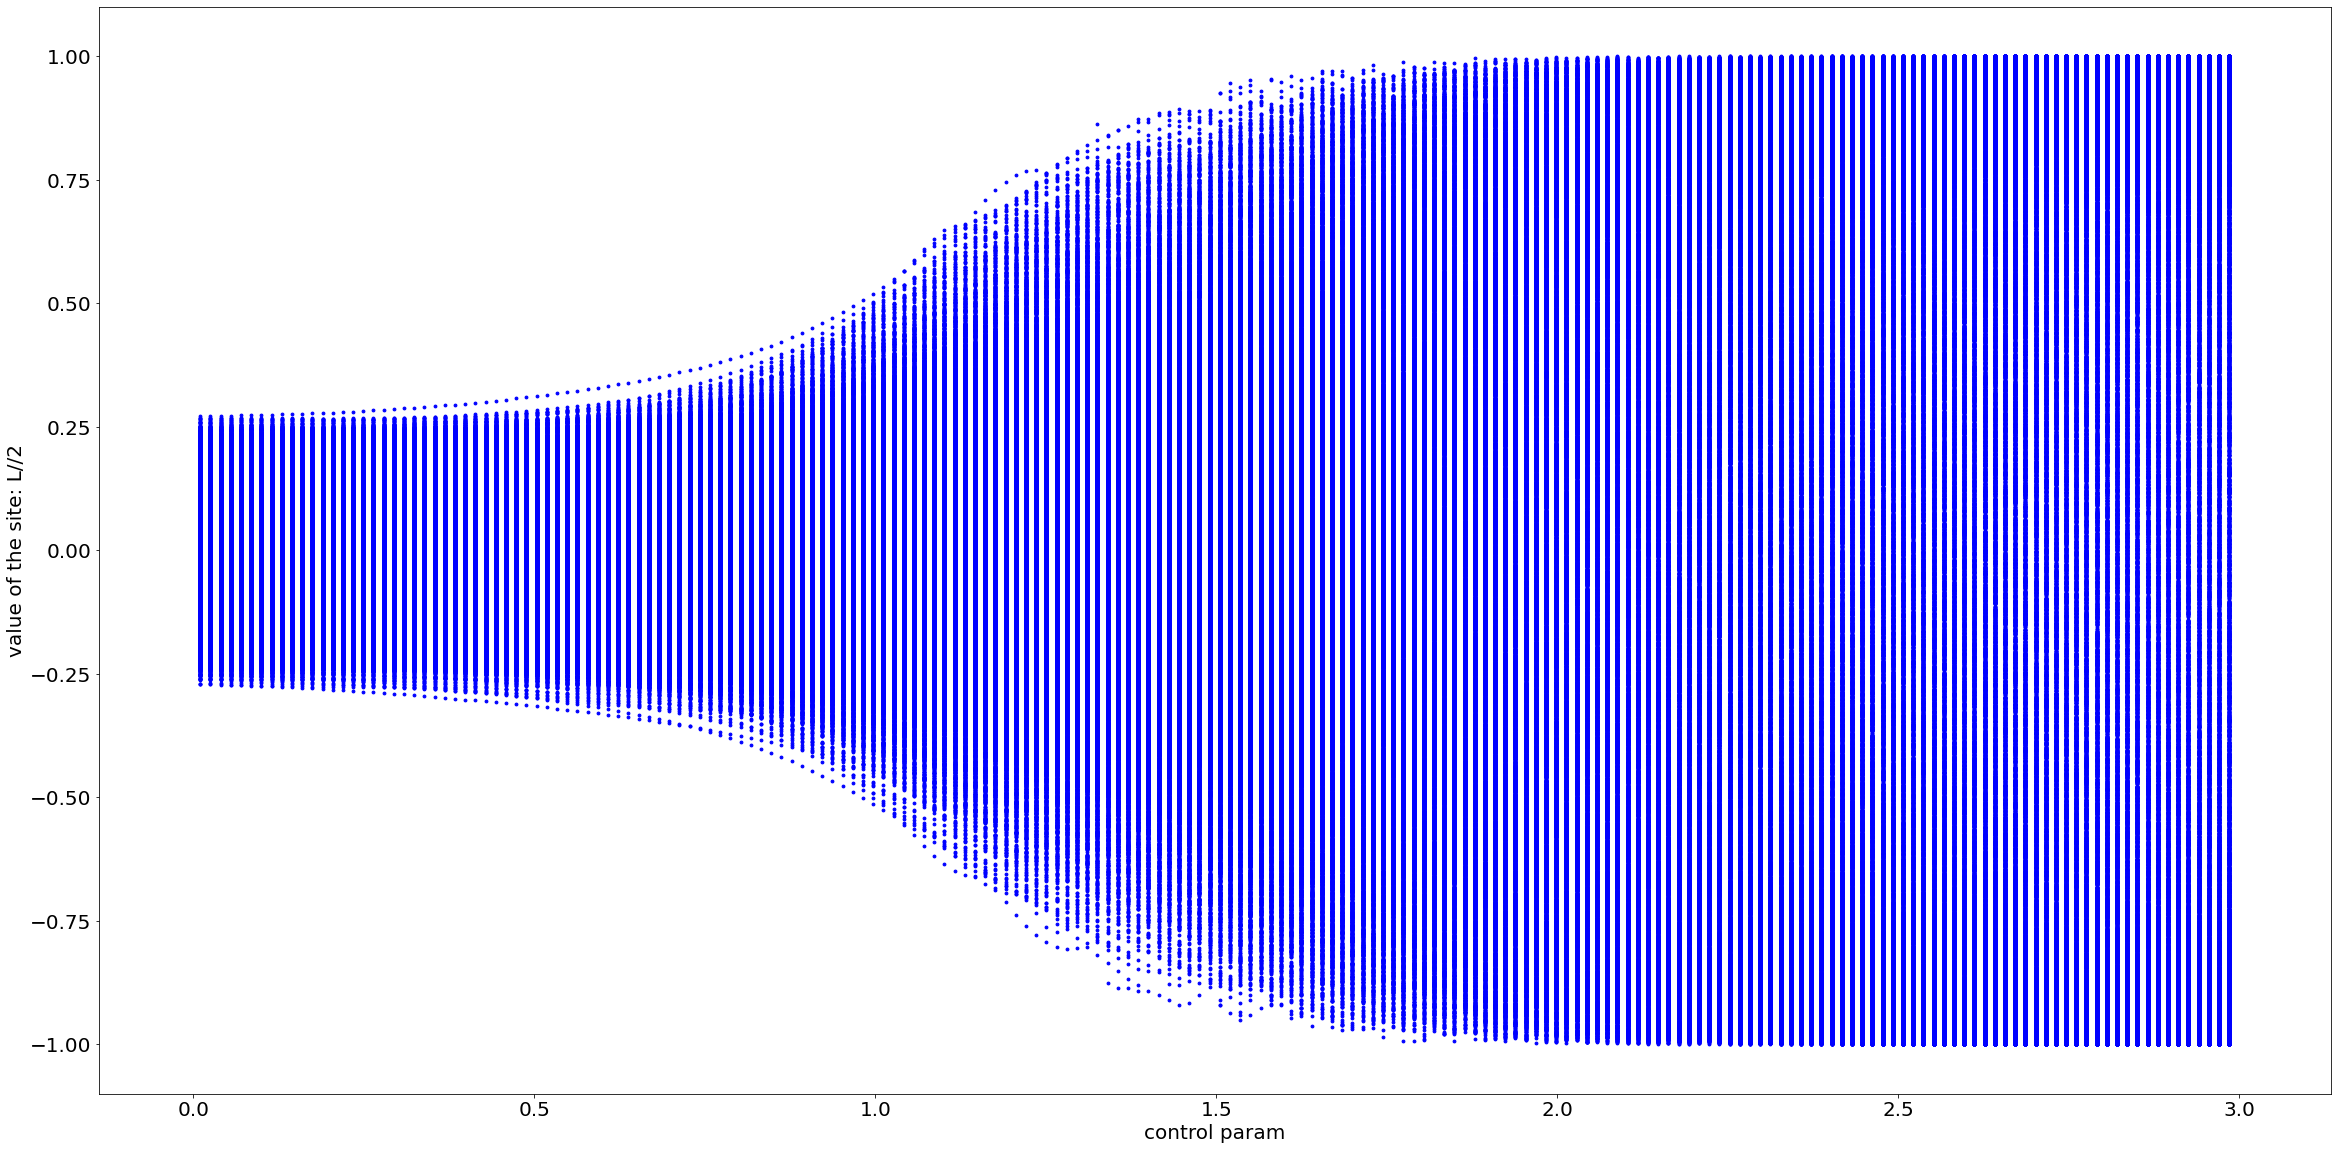

In [ ]:
np.random.seed(1010)
dim_u_spon=1
dim_rv=100
dim_u=1
Time_leng=8000

input_scale=1.0
density=1.0

u_ex=np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))
#print(u_ex)
rseed=1111

pLow = 0.01
pHigh = 3.00
nSteps = 200       # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

rhos = np.arange(pLow, pHigh, pInc)

plt.rcParams["figure.figsize"] = (40, 20)#(縦, 横)
fig=plt.figure()#(figsize=(100,100))
ax1=fig.subplots(1,1)
ax1.set_xlabel("control param",fontsize=20)
ax1.set_ylabel("value of the site: L//2",fontsize=20) 
j_ofx=1
for rho in rhos:
    washout_len, states_series=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, input_scale, rho, 
                                                rseed, spon_eps=0.20, spon_r=4.0, plot=False, verbose=False)
    ax1.scatter(rho*np.ones(Time_leng-washout_len), states_series[:,j_ofx], s=8, c='b')
plt.show

## 1spon

<function matplotlib.pyplot.show(*args, **kw)>

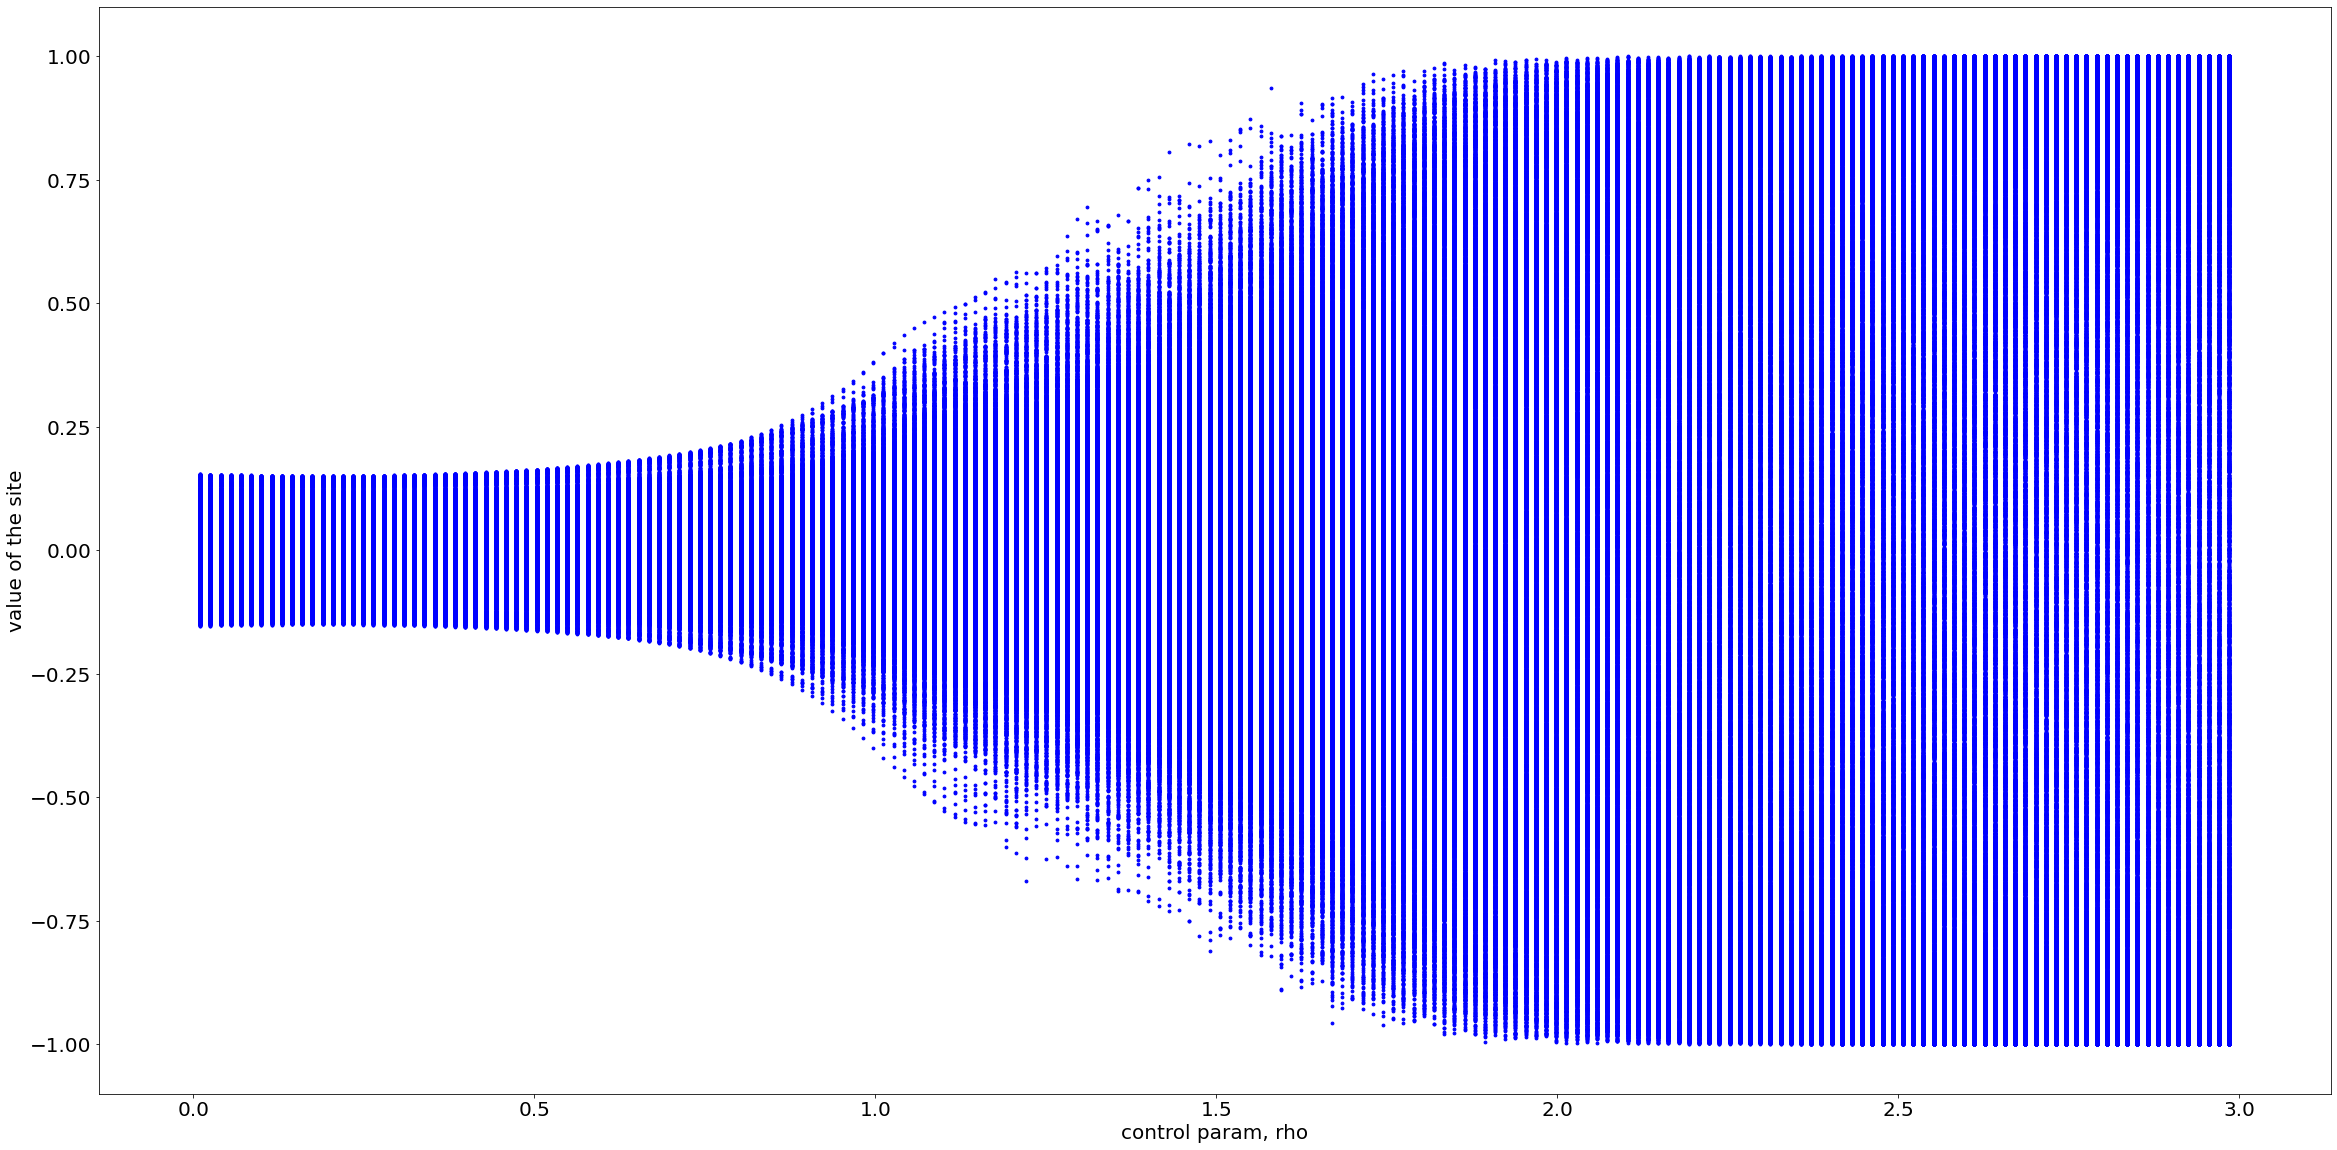

In [ ]:
np.random.seed(1010)
dim_u_spon=1
dim_rv=100
dim_u=0
Time_leng=8000

input_scale=1.0
density=1.0

u_ex=np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))
#print(u_ex)
rseed=1111

pLow = 0.01
pHigh = 3.00
nSteps = 200       # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

rhos = np.arange(pLow, pHigh, pInc)

plt.rcParams["figure.figsize"] = (40, 20)#(縦, 横)
fig=plt.figure()#(figsize=(100,100))
ax1=fig.subplots(1,1)
ax1.set_xlabel("control param, rho",fontsize=20)
ax1.set_ylabel("value of the site",fontsize=20) 
j_ofx=1
for rho in rhos:
    washout_len, states_series=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, input_scale, rho, 
                                                rseed, spon_eps=0.20, spon_r=4.0, plot=False, verbose=False)
    ax1.scatter(rho*np.ones(Time_leng-washout_len), states_series[:,j_ofx], s=8, c='b')
plt.show

## 1external

<function matplotlib.pyplot.show(*args, **kw)>

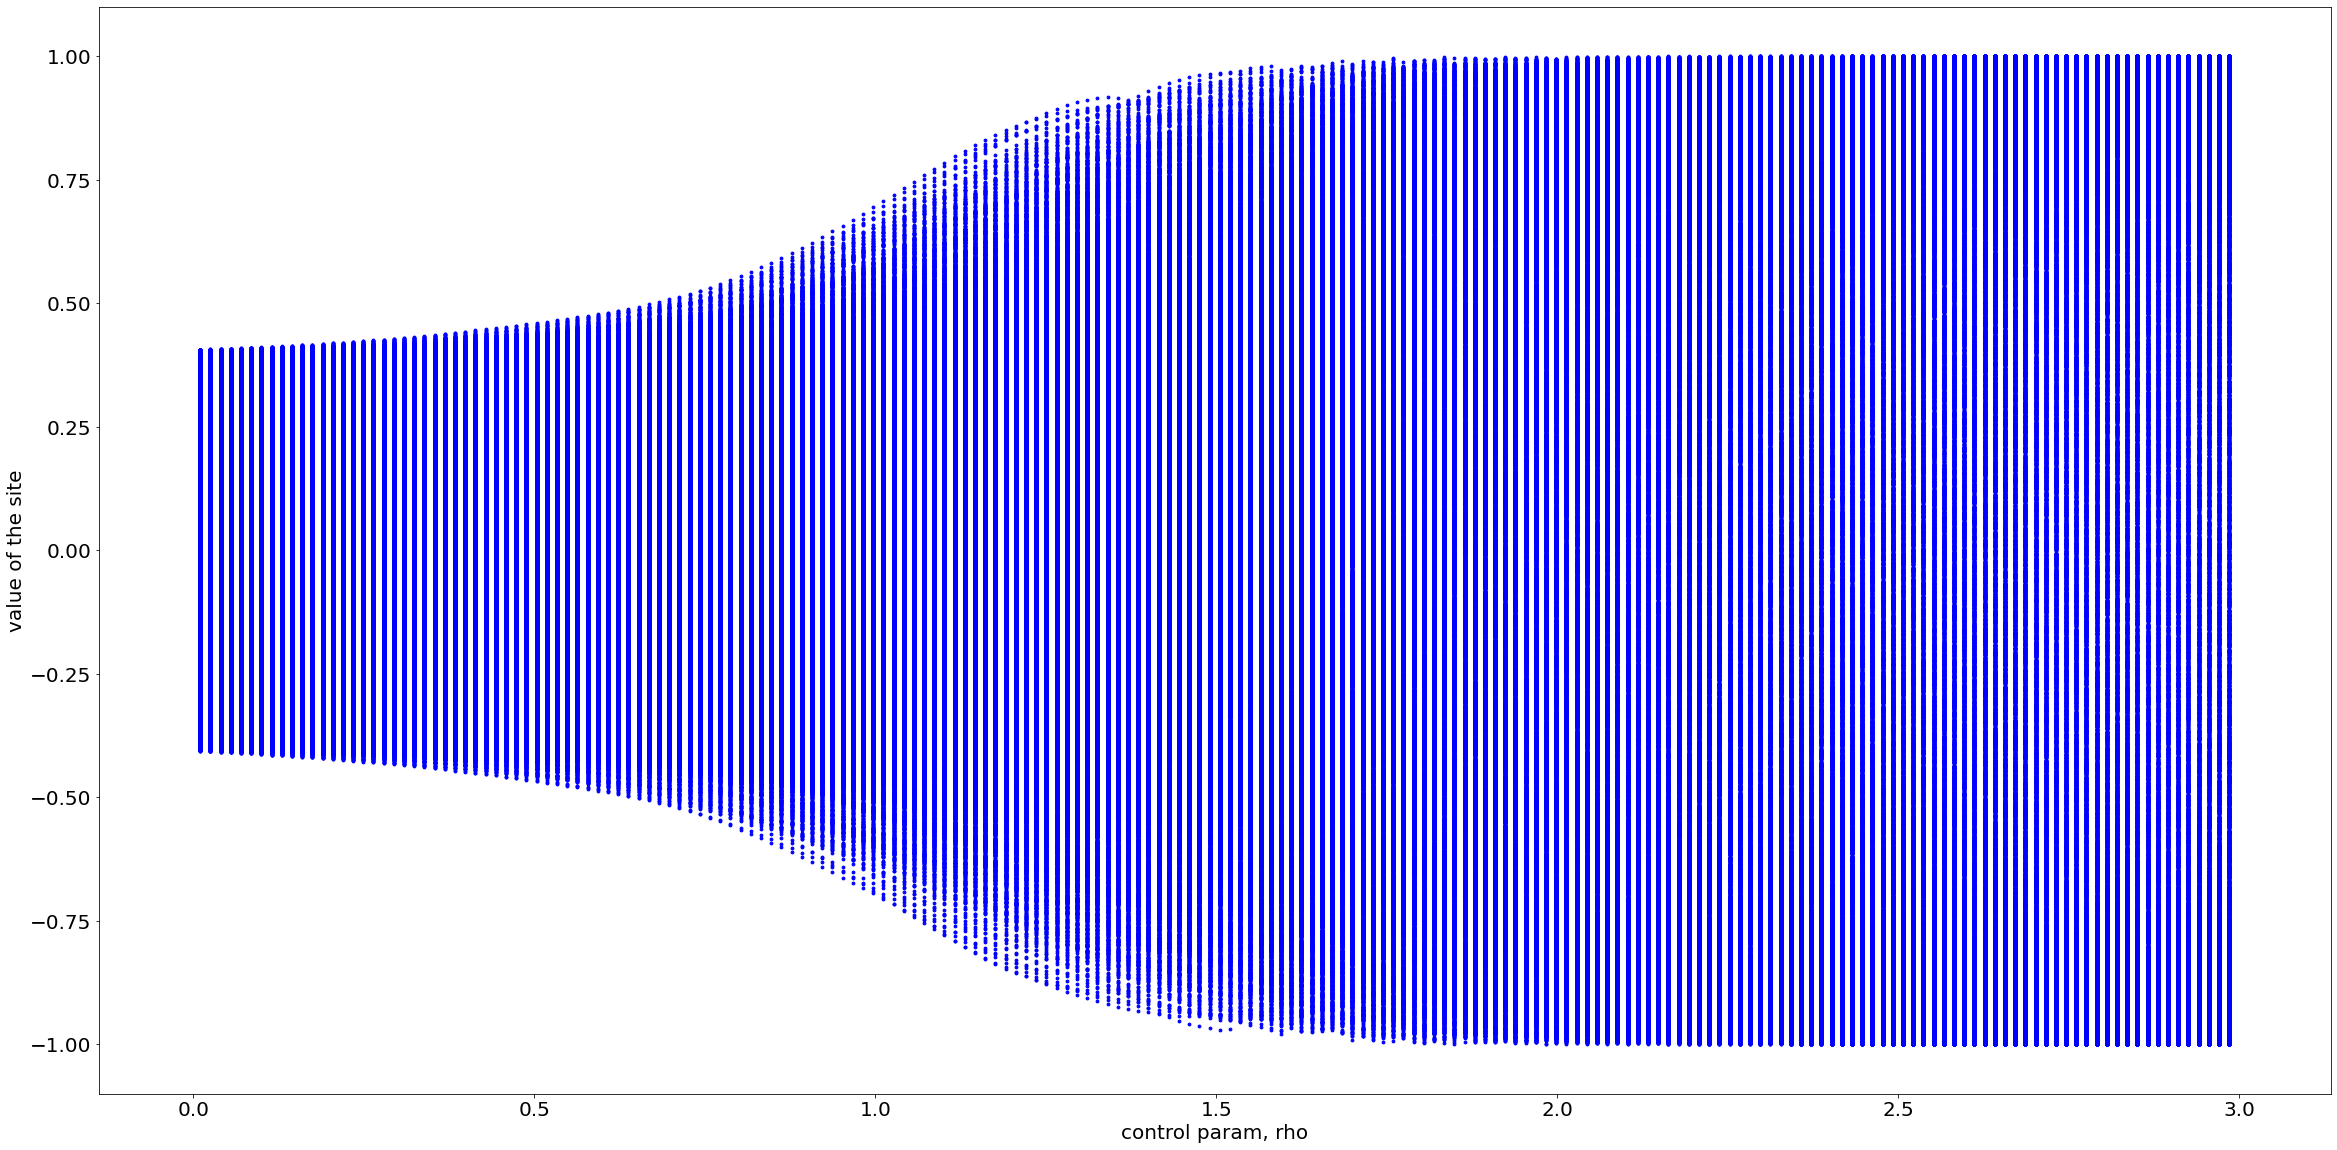

In [ ]:
np.random.seed(1010)
dim_u_spon=0
dim_rv=100
dim_u=1
Time_leng=8000

input_scale=1.0
density=1.0

u_ex=np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))
#print(u_ex)
rseed=1111

pLow = 0.01
pHigh = 3.00
nSteps = 200       # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

rhos = np.arange(pLow, pHigh, pInc)

plt.rcParams["figure.figsize"] = (40, 20)#(縦, 横)
fig=plt.figure()#(figsize=(100,100))
ax1=fig.subplots(1,1)
ax1.set_xlabel("control param, rho",fontsize=20)
ax1.set_ylabel("value of the site",fontsize=20) 
j_ofx=1
for rho in rhos:
    washout_len, states_series=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, input_scale, rho, 
                                                rseed, spon_eps=0.20, spon_r=4.0, plot=False, verbose=False)
    ax1.scatter(rho*np.ones(Time_leng-washout_len), states_series[:,j_ofx], s=8, c='b')
plt.show

# Change input_series 

## 1spon, 1external

<function matplotlib.pyplot.show(*args, **kw)>

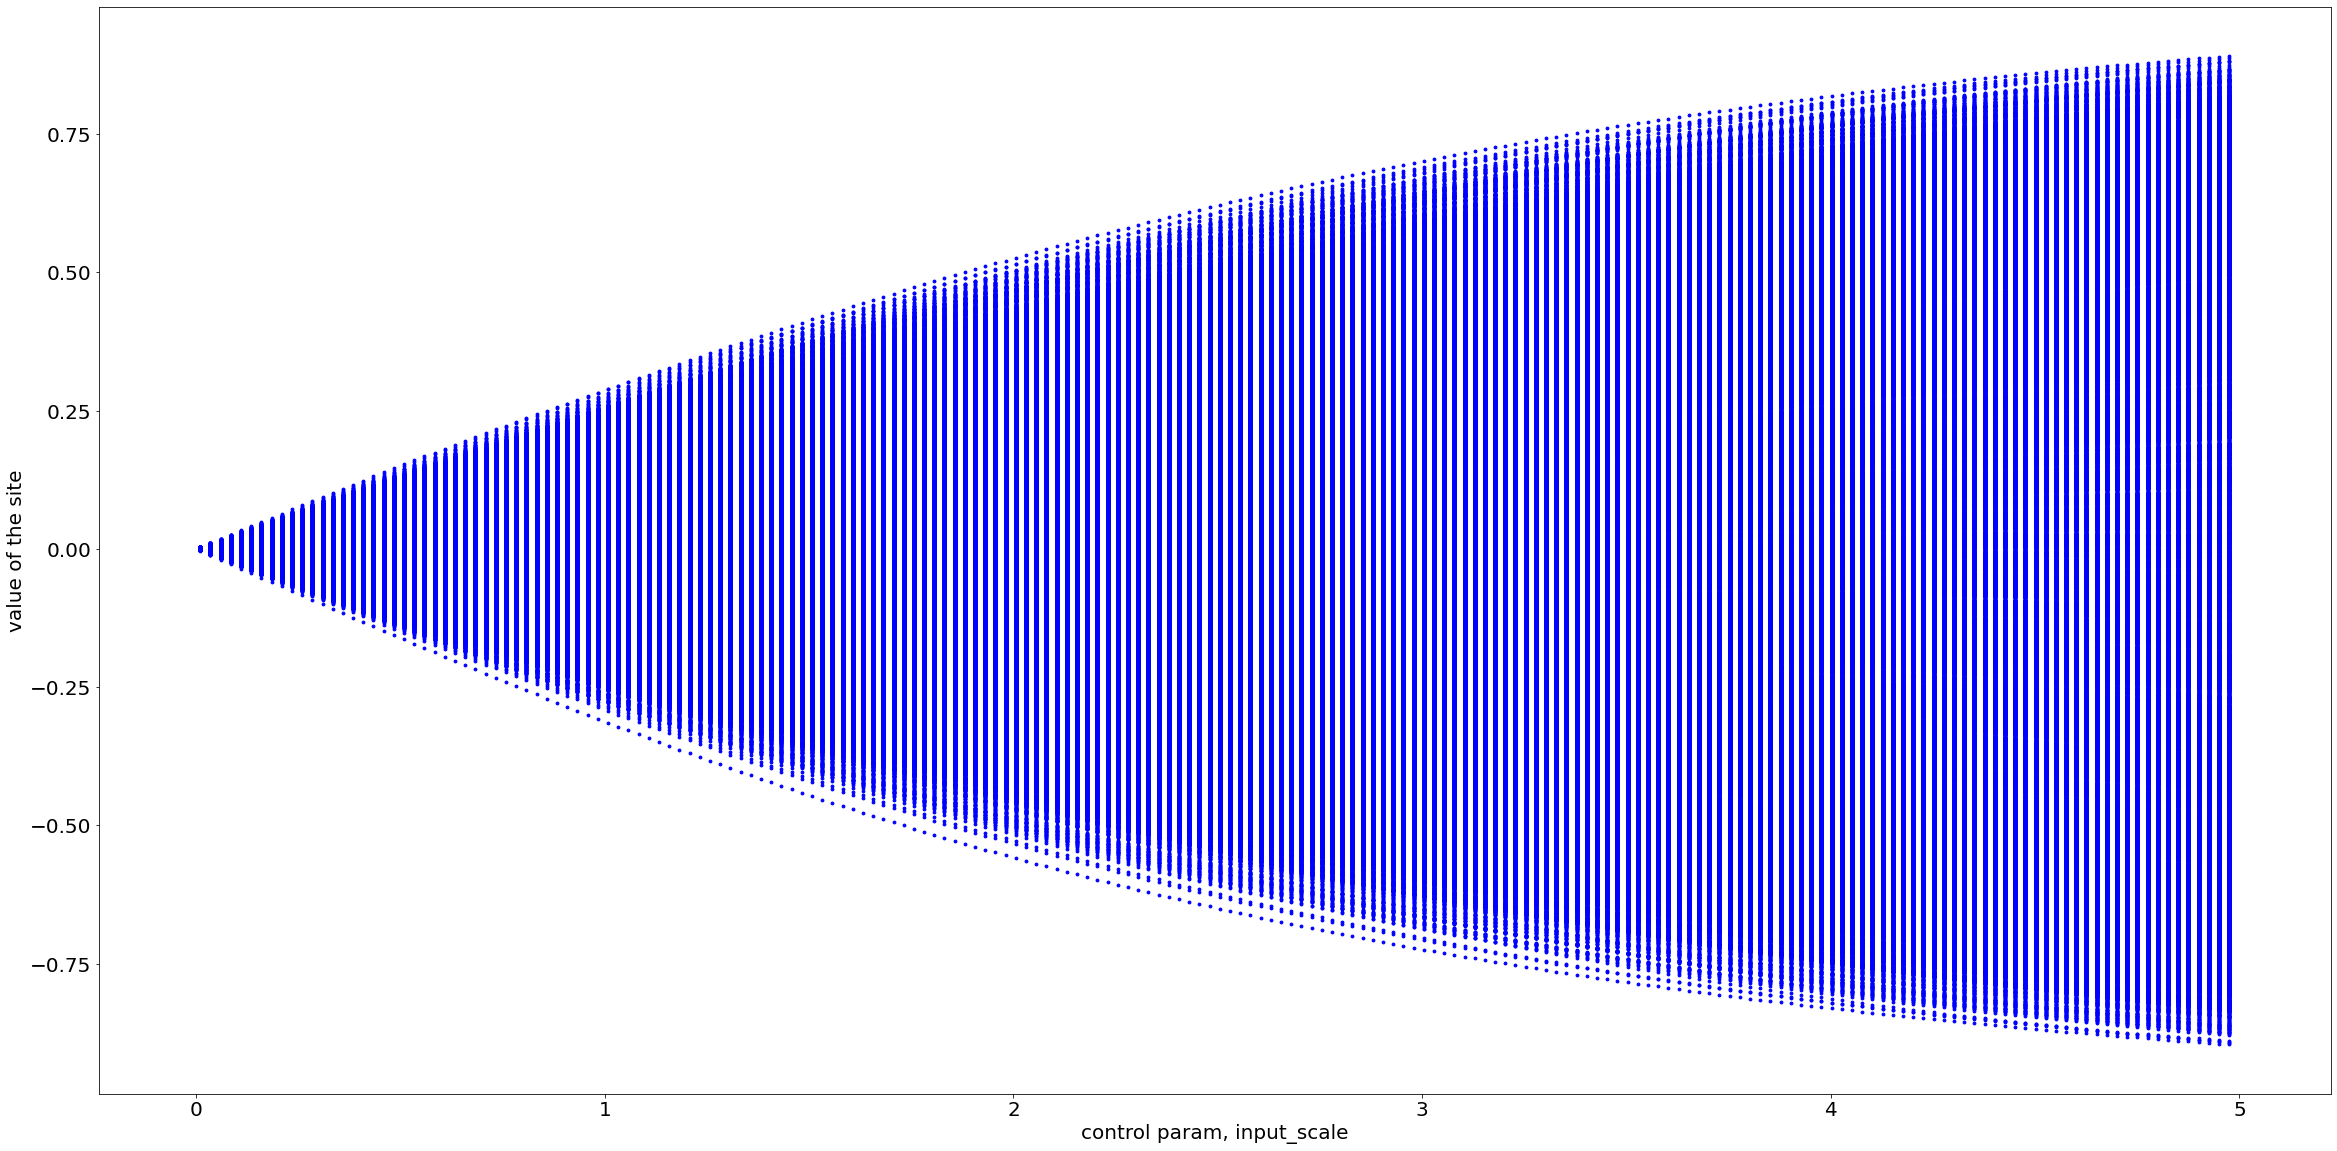

In [ ]:
dim_u_spon=1
dim_rv=100
dim_u=1
Time_leng=8000

rho=0.50
density=1.0

rseed=1111

pLow = 0.01
pHigh = 5.00
nSteps = 200       # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

input_scales = np.arange(pLow, pHigh, pInc)

plt.rcParams["figure.figsize"] = (40, 20)#(縦, 横)
fig=plt.figure()#(figsize=(100,100))
ax1=fig.subplots(1,1)
ax1.set_xlabel("control param, input_scale",fontsize=20)
ax1.set_ylabel("value of the site",fontsize=20) 
j_ofx=1
for input_scale in input_scales:
    u_ex=np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))
    washout_len, states_series=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, input_scale, rho, 
                                                rseed, spon_eps=0.20, spon_r=4.0, plot=False, verbose=False)
    ax1.scatter(input_scale*np.ones(Time_leng-washout_len), states_series[:,j_ofx], s=8, c='b')
plt.show

## 1spon

<function matplotlib.pyplot.show(*args, **kw)>

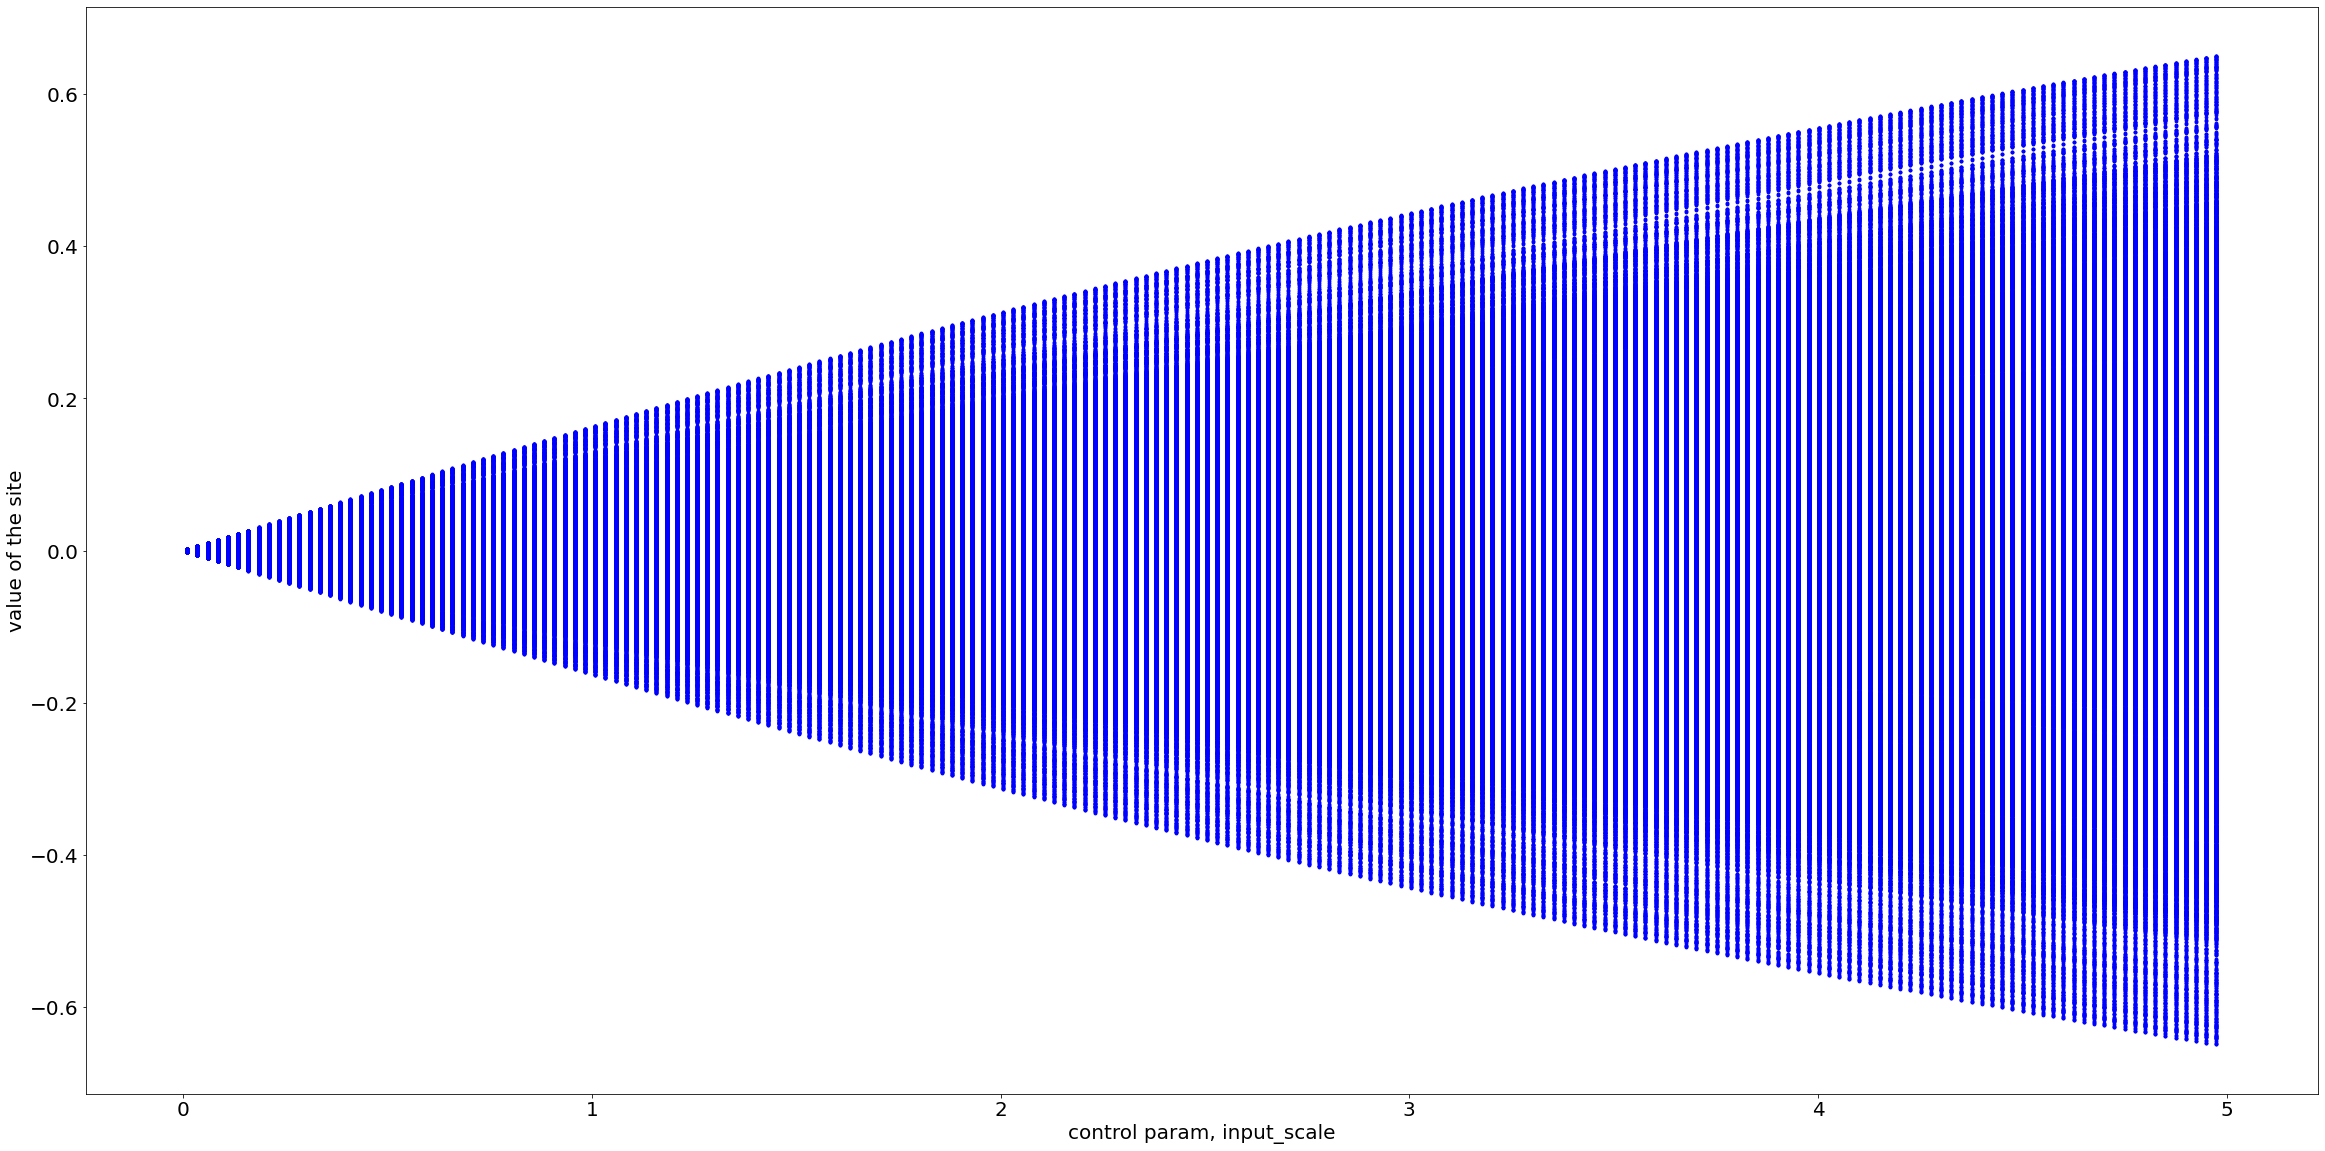

In [ ]:
dim_u_spon=1
dim_rv=100
dim_u=0
Time_leng=8000

rho=0.50
density=1.0

rseed=1111

pLow = 0.01
pHigh = 5.00
nSteps = 200       # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

input_scales = np.arange(pLow, pHigh, pInc)

plt.rcParams["figure.figsize"] = (40, 20)#(縦, 横)
fig=plt.figure()#(figsize=(100,100))
ax1=fig.subplots(1,1)
ax1.set_xlabel("control param, input_scale",fontsize=20)
ax1.set_ylabel("value of the site",fontsize=20) 
j_ofx=1
for input_scale in input_scales:
    u_ex=np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))
    washout_len, states_series=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, input_scale, rho, 
                                                rseed, spon_eps=0.20, spon_r=4.0, plot=False, verbose=False)
    ax1.scatter(input_scale*np.ones(Time_leng-washout_len), states_series[:,j_ofx], s=8, c='b')
plt.show

## 1external

<function matplotlib.pyplot.show(*args, **kw)>

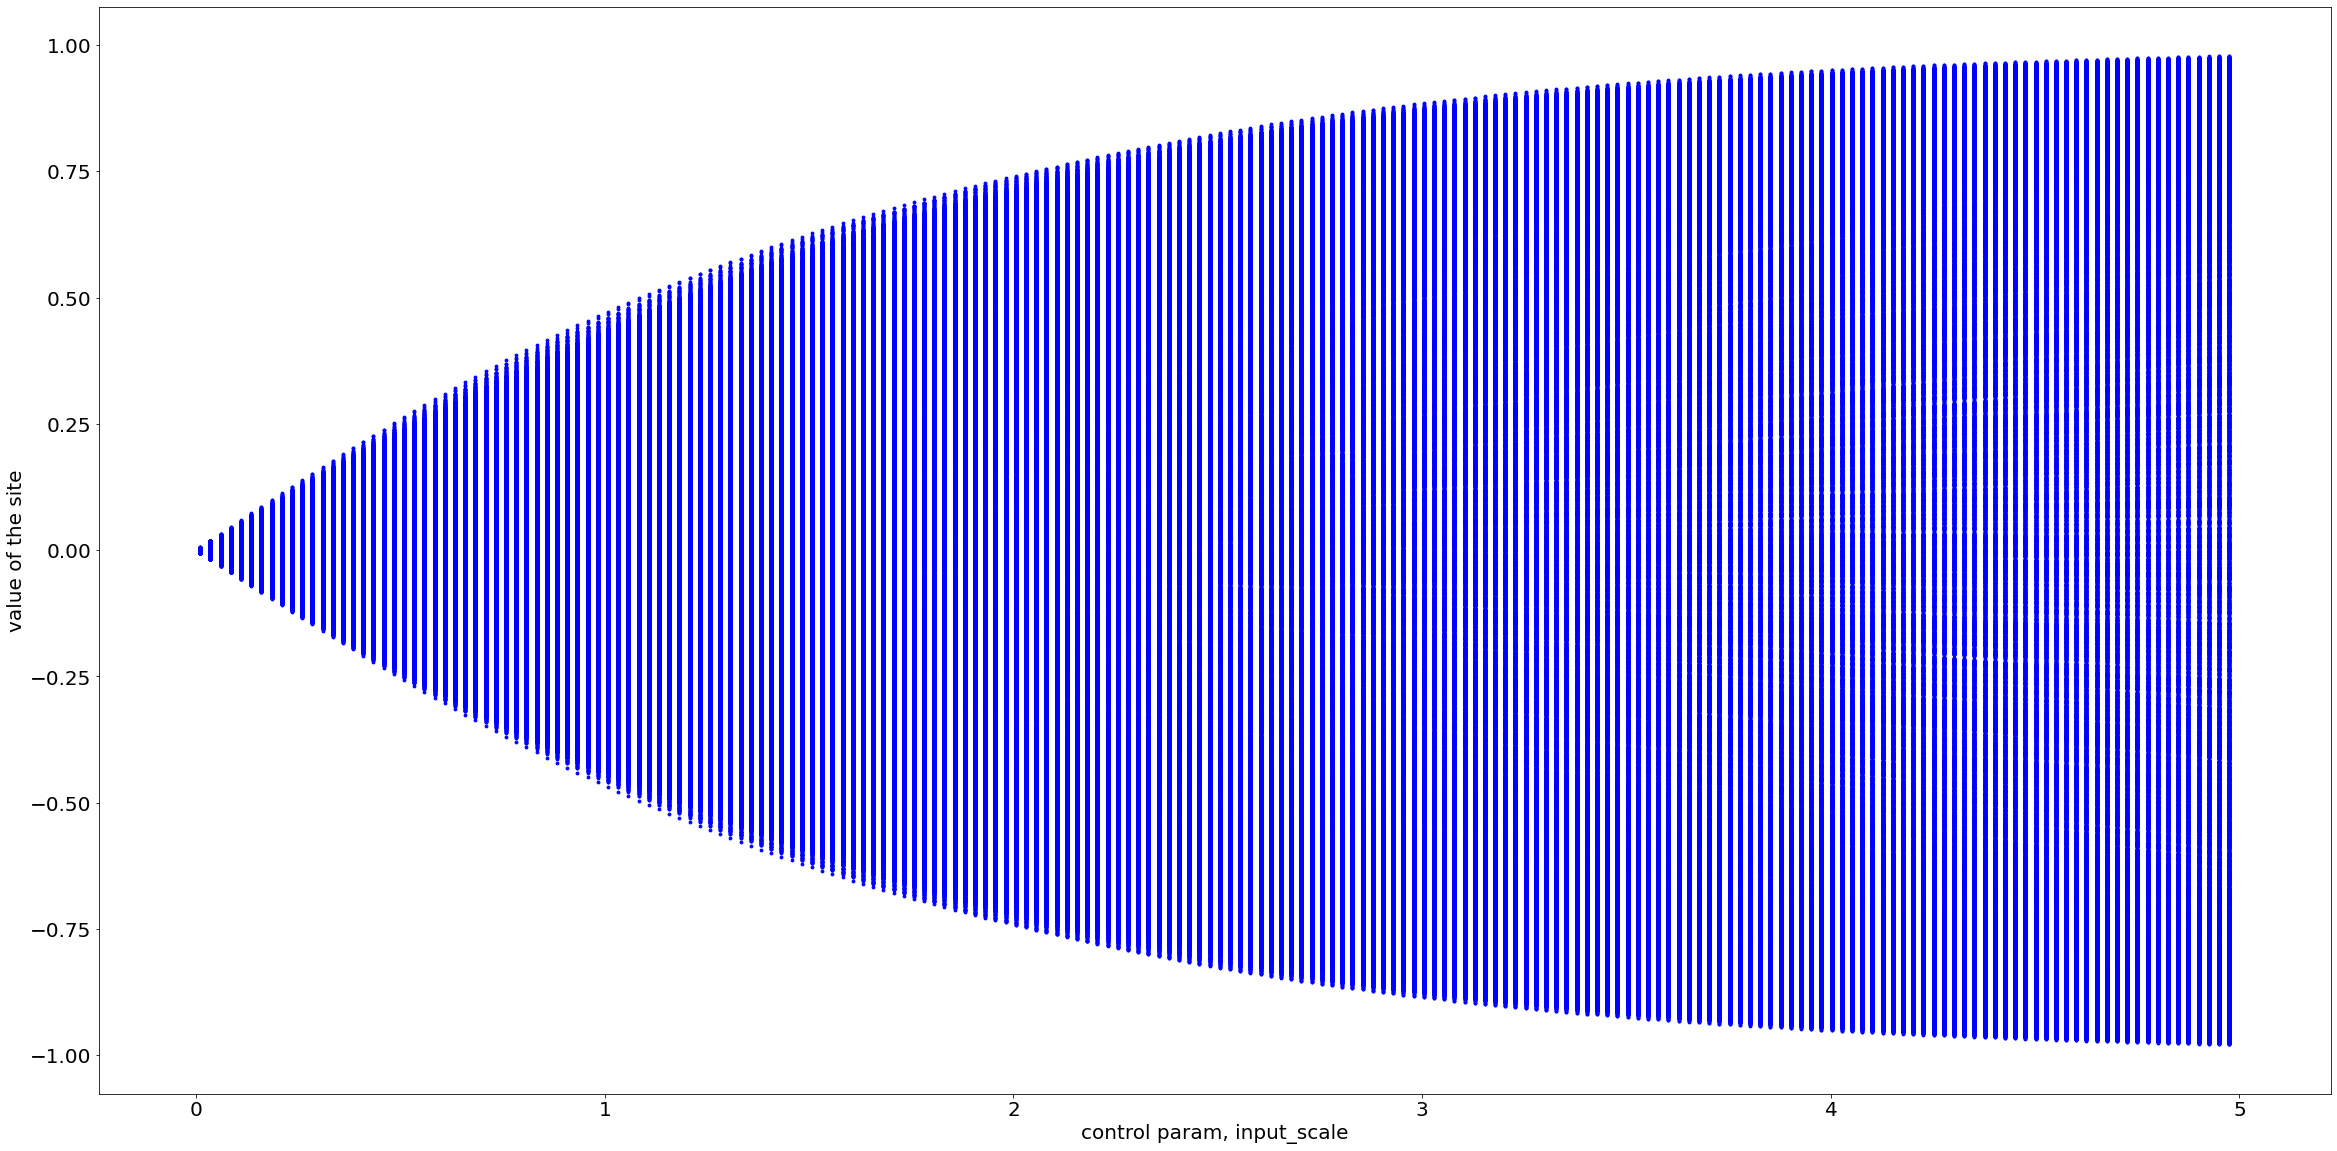

In [ ]:
dim_u_spon=0
dim_rv=100
dim_u=1
Time_leng=8000

rho=0.50
density=1.0

rseed=1111

pLow = 0.01
pHigh = 5.00
nSteps = 200       # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

input_scales = np.arange(pLow, pHigh, pInc)

plt.rcParams["figure.figsize"] = (40, 20)#(縦, 横)
fig=plt.figure()#(figsize=(100,100))
ax1=fig.subplots(1,1)
ax1.set_xlabel("control param, input_scale",fontsize=20)
ax1.set_ylabel("value of the site",fontsize=20) 
j_ofx=1
for input_scale in input_scales:
    u_ex=np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))
    washout_len, states_series=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, input_scale, rho, 
                                                rseed, spon_eps=0.20, spon_r=4.0, plot=False, verbose=False)
    ax1.scatter(input_scale*np.ones(Time_leng-washout_len), states_series[:,j_ofx], s=8, c='b')
plt.show

# 完成版11/18 

washout_len, CML 初期値を代入できるようにする(seed値変更で対処した.)

x_in_spon(CMLのstate_series)をとりだせるように

input_externalだけinput-scaleを変更できるようにする
→元から外部からわたす時に設定できるようになっている.

## ESN, output, input class
input, output, middle layer

In [ ]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import networkx as nx
from numpy.random import RandomState
import matplotlib.pyplot as plt
import copy

class Input_external:
    def __init__(self, dim_u, dim_x, input_scale, dtype=np.float32, rseed=0):
        '''
        dim_u: Dimension of the input
        dim_x: Dimension of the reservoir states = Number of nodes in the Reservoir Network
        input_scale: Scaling coefficient for the input
        '''
        np.random.seed(seed=rseed)
        self.dtype = dtype
        #only first neuron receives noise
        #self.w_in = np.zeros((dim_x, dim_u))
        #self.w_in[:, 0]=np.random.uniform(-input_scale, input_scale, dim_u).T
        self.w_in = np.random.uniform(-input_scale, input_scale, (dim_x, dim_u))
        self.w_in = self.w_in.astype(self.dtype)

    
    def __call__(self, u):
        u = u.astype(self.dtype)
        return np.dot(self.w_in, u)

class Input_spon:
    def __init__(self, dim_u_spon, dim_x, input_scale=1.0, eps=0.20, r=4.0, dtype=np.float32, rseed=0):
        '''
        dim_u_spon: Dimension of the input from sponttaneous activities
        dim_x: Dimension of the reservoir states = Number of nodes in the Reservoir Network
        input_scale: Scaling coefficient for the input
        '''
        np.random.seed(seed=0)
        self.input_scale=input_scale # variant for buf
        self.dtype = dtype
        self.w_in = np.random.uniform(-self.input_scale, self.input_scale, (dim_x, dim_u_spon))
        self.w_in = self.w_in.astype(self.dtype)

        self.eps=eps # diffusive coupling strength
        self.r=r # control parameter r

        np.random.seed(seed=rseed)
        L = 2      # no. of lattice sites
        ic = np.random.uniform(0.1, 0.9, (L, dim_u_spon))  # random initial condition betn. (0,1)
        #print("spon_act_CML2d_ic = ", ic)
        self.CML2d=ic
        self.x_in_series=[] #1st_dim: time, 2nd_dim: input_dim(dim_u_spon)
    
    def logistic(self, r, xforlog):
        return r*xforlog*(1-xforlog)
    
    def func1(self, a, x):
        return 1-(a*x)*x
    
    def next_x(self, f, x_2d):
        x_new = np.empty(x_2d.shape)
        x_new[0] = (1 - self.eps) * f(self.r,x_2d[0]) + self.eps * f(self.r,x_2d[1])
        x_new[1] = (1 - self.eps) * f(self.r,x_2d[1]) + self.eps * f(self.r,x_2d[0])
        return x_new

    def get_x_in(self):
        return np.array(self.x_in_series)

    def __call__(self):
        self.CML2d = self.next_x(self.logistic, self.CML2d).astype(self.dtype)# intermittent activities 2dCML or ESNnetwork
        self.x_in_spon=self.CML2d[0]-self.CML2d[1]
        #print(self.CML2d)
        self.x_in_series.append(self.x_in_spon)
        return np.dot(self.w_in, self.x_in_spon)# x_in is row or clumn??????

class ESN1:
    def __init__(self, dim_x, activation_func=np.tanh, dtype=np.float32, rho=0.9,
        x_init=None, rseed=None, density=None):
        '''
        dim_x:           Dimension of the reservori states = Number of nodes in the Reservoir Network
        activation_func: Activation function to evolve the previous internal states
        rho:             Specified spectral radius for the internal weights matrix
        density:         Density of connection in the Reservoir layer
        '''
        self.dim_x = dim_x
        self.f = activation_func
        self.dtype = dtype
        self.rho = rho # speficy the spectral radius
        
        if x_init is None:
            self.x_init = np.zeros(dim_x, dtype=self.dtype)
        else:
            self.x_init = np.array(x_init, dtype=self.dtype)
        self.x = np.array(self.x_init)
        self.rseed = rseed
        self.rnd = RandomState(rseed)
        
        # initializing internal connections
        self.reset_weight(density)
    
    def reset_weight(self, density=None):
        
        self.density = 1.0 if density is None else density
        num_edges = int(self.dim_x * (self.dim_x - 1) * self.density / 2)
        
        G = nx.gnm_random_graph(self.dim_x, num_edges, self.rseed)
        self.w_net = np.array(nx.to_numpy_matrix(G))
        self.w_net = self.w_net.astype(self.dtype)
        self.w_net *= self.rnd.uniform(-1.0, 1.0, (self.dim_x, self.dim_x))
        
        # Compute spectral radius
        eigv_list = np.linalg.eig(self.w_net)[0]
        spectral_radius = np.max(np.abs(eigv_list))

        # Normalize the spectral radius
        self.w_net  *= self.rho / spectral_radius
        """
        self.w_net  =[[1.0, 0.1, -0.9, -0.3],
                      [0.5, 0.9, 0.2, 0.0],
                      [-0.7, 0.4, -0.3, 0.1],
                      [0.5, 0.1, 0.2, 1.0]]
        """

    def f_act(self, x=None):
        if x is None:
            x = self.x
            print("error")
        return self.f(x)
    
    def update(self, x_in):
        x_in = x_in.astype(self.dtype)
        
        self.x = self.f_act(np.dot(self.w_net, self.x) + x_in)
        #print("self.x[0] = ", buf_x[0], "  (np.dot(self.w_net, self.x) + x_in)[0] = ", (np.dot(self.w_net, self.x) + x_in)[0])
        #print("np.tanh( (np.dot(self.w_net, self.x) + x_in)[0]) =", np.tanh((np.dot(self.w_net, self.x) + x_in)[0]) )

    def reset_states(self, x_init=None):# not used 
        if x_init is None:
            x_init = self.x_init
        self.x = np.array(x_init)

    def get_states(self):
        return self.x

class Readout:
    def __init__(self, dim_x, dim_out, rseed=0):
        np.random.seed(seed=rseed)
        self.w_out = np.random.normal(size=(dim_out, dim_x))
    
    def __call__(self, x):
        return np.dot(self.w_out, x)
    
    def set_weight(self, w_out_opt):
        self.w_out = w_out_opt


## Discrete ESN for checking state values

In [ ]:
class DESN_2kindsInput_1(ESN1):
    '''
    Discrete-time echo state network
    Inherit from ESN abstract class
    Add the Input and Readout layers
    
    #Variables including default params have order to define in any function 
    '''
    def __init__(self, dim_u_ex, dim_u_spon, dim_rv, input_scale, activation_func, 
                 rseed=0, seed_spon=0, spon_eps=0.20, spon_r=4.0, dim_out=0,**kwargs):
        #dim_rv: Dimension of the reservoir states
        super(DESN_2kindsInput_1, self).__init__(dim_rv, activation_func=activation_func, **kwargs)#assign dim_rv to dim_x
        #create instance
        self.Input_external = Input_external(dim_u_ex, dim_rv, input_scale, rseed=rseed)
        self.Input_spon = Input_spon(dim_u_spon, dim_rv, input_scale=input_scale, eps=spon_eps, r=spon_r, rseed=seed_spon)
        
        self.Readout = Readout(dim_rv, dim_out)
        self.states_series=[]
        self.dim_u_spon=dim_u_spon
        self.dim_u_ex=dim_u_ex

    def one_step(self, u_in):
        '''
        One-step evolution
        '''
        # Contribution from input
        x_in_external = self.Input_external(u_in)
        # Contribution from spontaneous activities
        x_in_spon = self.Input_spon()
        # Update with previous states and activation function
        self.update( (x_in_external + x_in_spon)/(self.dim_u_spon + self.dim_u_ex) )

    def time_elapse(self, u_seq, washout_len = 200):
        '''
        Do not use the data in the washout phase for training
        '''
        for i in range(len(u_seq)):
            # Update the reservoir states
            self.one_step(u_seq[i])
            if i >= washout_len: 
              # True: use data
              self.states_series.append(self.get_states())
        return np.array(self.states_series)
    
    def predict(self, u_seq):
        '''
        Given the input sequence u_seq, predict the unknown output sequence
        Using the trained readout weights
        '''
        Y_pred_seq = []
        for i in range(len(u_seq)):
            self.one_step(u_seq[i])
            x_bias = np.concatenate([np.ones(1), self.x])
            y_pred = self.Readout(x_bias)
            Y_pred_seq.append(y_pred)
        return np.array(Y_pred_seq)

## Observation of DESN with spontaneous acts

np.diff(): 渡した配列の階差数列を配列で返す関数

In [ ]:
def DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, input_scale, rho, rseed=0, activation_func=np.tanh, 
                    washout_len=0, seed_spon=0, spon_eps=0.20, spon_r=4.0, plot=True, verbose=False):
    # Obtain the dimension of input and output
    dim_u_ex = u_ex.shape[1]
    Time_leng=u_ex.shape[0]
    dim_u_spon=dim_u_spon
    #dim_out = train_y.shape[1]
    #print("dim_out = ",dim_out)
    
    # Define the model
    model = DESN_2kindsInput_1(seed_spon=seed_spon, dim_u_ex=dim_u_ex, dim_u_spon=dim_u_spon, dim_rv=dim_rv, 
                             density=density, input_scale=input_scale, activation_func=activation_func, 
                             spon_eps=spon_eps, spon_r=spon_r, rho=rho, rseed=rseed)
    
    washout_len=washout_len
    # Time elapsed (時間が経過した-> 時間経過)
    states_series = model.time_elapse(u_ex, washout_len=washout_len) # 1st_dim: time, 2nd: nodes.
    x_in_spon=model.Input_spon.get_x_in()
    # Predict
    """
    test_pred = model.predict(test_u)
    print("test_pred.shape", test_pred.shape)
    """
    # Evaluate
    
    # For Debug
    if verbose == True:
        print("Debug")
        print("dim_u = ",dim_u)
        print("x_in_spon.shape = ", x_in_spon.shape)
        print("states_series.shape = ", states_series.shape)
        #print(states_series[0])

     # Plot the target
    if (plot == True and dim_u_spon == 0):
        plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
        plt.rcParams['font.size'] = 20
        fig=plt.figure()
        ax1=fig.subplots(2,1)

        time=np.arange(Time_leng)

        bar1=ax1[0].imshow(states_series.T, cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[0].set_xlabel('time')
        ax1[0].set_ylabel('nodes')
        fig.colorbar(bar1, ax=ax1[1])

        bar2=ax1[1].imshow(states_series.T[:, -300:], cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[1].set_xlabel('time')
        ax1[1].set_ylabel('nodes')
        fig.colorbar(bar2, ax=ax1[1])
    
    # Plot the targett with spon_act
    if (plot == True and dim_u_spon>0):
        plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
        plt.rcParams['font.size'] = 20
        fig=plt.figure()
        ax1=fig.subplots(3,1)

        time=np.arange(Time_leng)
        ax1[0].plot(time, x_in_spon)

        bar1=ax1[1].imshow(states_series.T, cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[1].set_xlabel('time')
        ax1[1].set_ylabel('nodes')
        fig.colorbar(bar1, ax=ax1[1])

        bar2=ax1[2].imshow(states_series.T[:, -300:], cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[2].set_xlabel('time')
        ax1[2].set_ylabel('nodes')
        fig.colorbar(bar2, ax=ax1[2])

        plt.show()
    return x_in_spon, states_series


Debug
dim_u =  1
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 100)


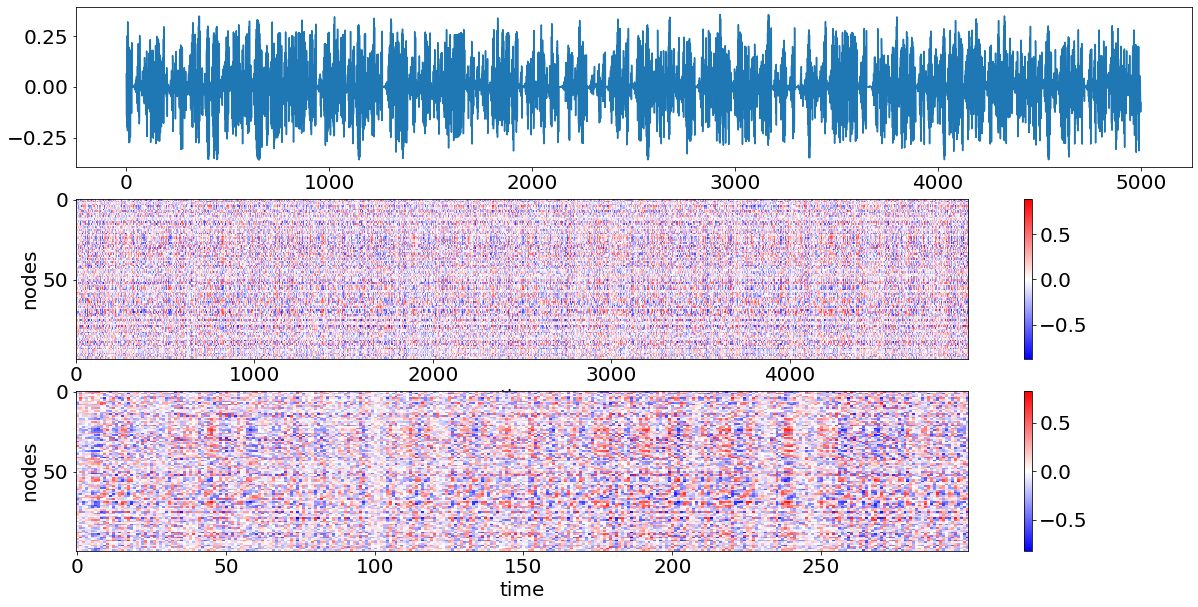

In [ ]:
np.random.seed(1010)
dim_u_spon=1
dim_rv=100
dim_u=1
Time_leng=5000

input_scale=1.0
rho=0.9
density=1.0

u_ex=np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))
#print(u_ex)
rseed=1111
washout_len, states_series1=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, input_scale, rho, rseed, 
                                            seed_spon=1, washout_len=0, spon_eps=0.20, spon_r=4.0, plot=True, verbose=True)

Debug
dim_u =  1
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 100)


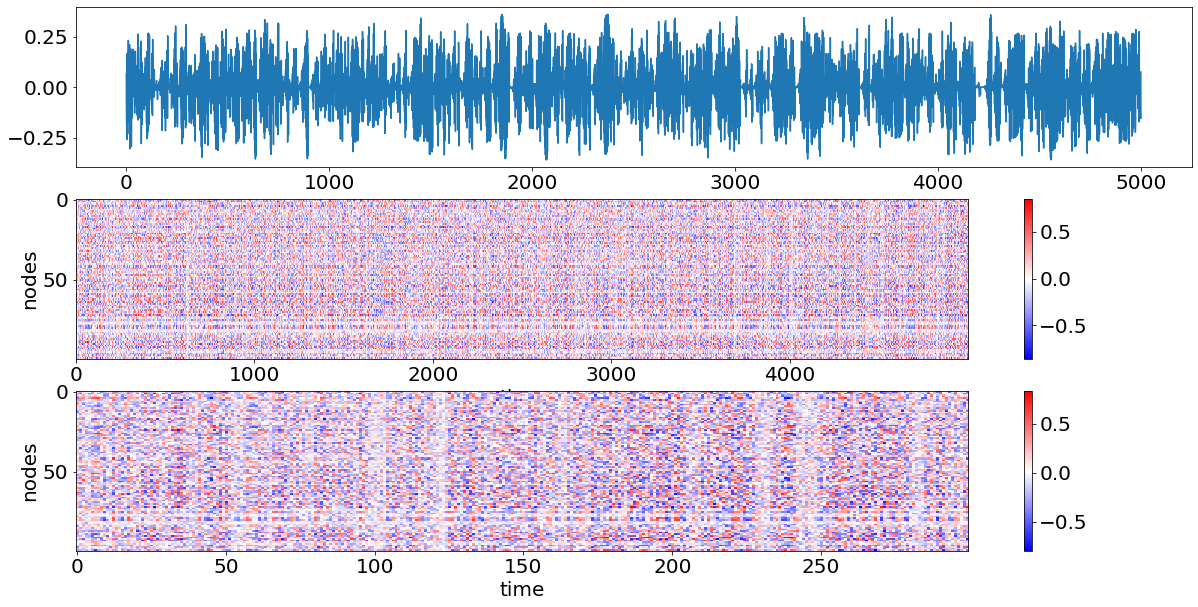

In [ ]:
np.random.seed(1010)
dim_u_spon=1
dim_rv=100
dim_u=1
Time_leng=5000

input_scale=1.0
rho=0.9
density=1.0

u_ex=np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))
#print(u_ex)
rseed=1111
washout_len, states_series1=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, input_scale, rho, rseed, 
                                            seed_spon=0, washout_len=0, spon_eps=0.20, spon_r=4.0, plot=True, verbose=True)